# Compare ideal infomax filter with the retina's horizontal and amacrine cell projective fields

In [217]:
import numpy as np
from scipy.stats import sem

# import my functions
import info_theory_functions as info
from lnl_model_functions import *
from atick_redlich_functions import *
from get_davids_data import *
from image_processing_functions import *

# from scipy.optimize import minimize
# from scipy import fft, arange
# from random import randint
# from cmath import polar
# from numpy.fft import fft2
# from numpy.fft import fftshift
# from sklearn.decomposition import PCA
# from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import sem


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
# I recommend against enabling the whole notebook, since some plots come out funny.
# Instead, just use mpld3.display() at the end of cells you want to interact with.
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import natural images

In [143]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/Documents/Natural_Images/RawData/cd13A' # flood plain, water, horizon
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 78 files in directory.


In [144]:
allRot  = [spectrum2d(p,spacing=spacing,frequencyFlag=False) for p in patches]
specRot = mean(allRot, axis=0) # average out the amplitude spectrum over all images
frqRot, tmp = spectrum2d(patches[0],spacing=spacing,frequencyFlag=True)
error = [sem([allRot[j][i] for j in range(len(patches))]) for i in range(len(frqRot))]
originalSpectra = specRot
originalErrors  = error
originalFreqs   = frqRot

# Check if horizontal/vertical fft2 scale matches rotavg scale

In [4]:
patches_fft2 = [abs(np.fft.fft2(p))/np.prod(p.shape) for p in patches]
patches_horz = [np.mean(p, axis=0)[:p.shape[0]/2+1] for p in patches_fft2]
patches_vert = [np.mean(p, axis=1)[:p.shape[1]/2+1] for p in patches_fft2]

In [5]:
freqs_horz   = np.linspace(0, 1./(2.*(2./92)), len(patches_horz[0]))
freqs_vert   = np.linspace(0, 1./(2.*(2./92)), len(patches_vert[0]))

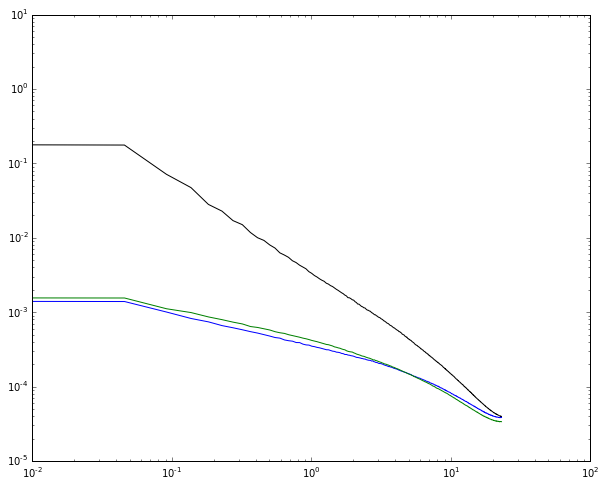

In [6]:
plot(originalFreqs, originalSpectra, 'k')
plot(freqs_horz, np.mean(patches_horz, axis=0), 'b')
plot(freqs_vert, np.mean(patches_vert, axis=0), 'g')
xscale('log')
yscale('log')

# Check different PCA modes (weight space by temporal PCA)

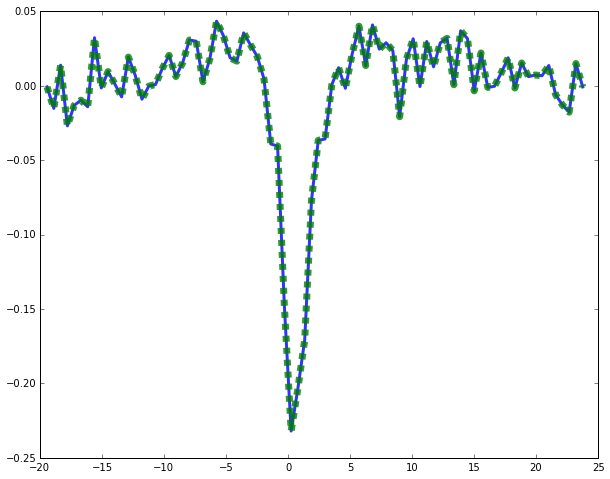

In [218]:
spatial_rfs_time  = load_ganglion_cells(pca_mode='time')
spatial_rfs_space = load_ganglion_cells(pca_mode='space')

plot(spatial_rfs_time[0][0], spatial_rfs_time[0][1], 'b', linewidth=3, alpha=0.8)
plot(spatial_rfs_space[0][0], spatial_rfs_time[0][1], 'g--', linewidth=7, alpha=0.8)

## So the two methods are identical

# Get the projective fields of horizontal and amacrine cells

In [219]:
microns_per_deg  = 50.
horz_spatial_pfs = get_horizontal_projective_field(micronsPerDeg=microns_per_deg)
horz_spatial_rfs = load_horizontal_cells(micronsPerDeg=microns_per_deg)
ama_spatial_pfs  = get_amacrine_projective_field(micronsPerDeg=microns_per_deg)
ama_spatial_rfs  = load_amacrine_cells(micronsPerDeg=microns_per_deg)

(-0.1, 2)

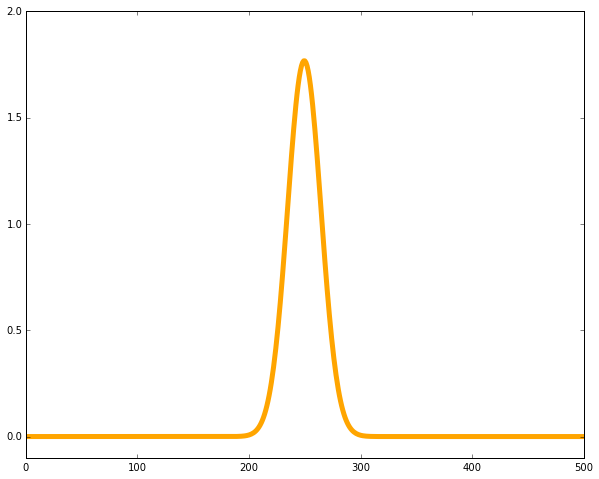

In [220]:
plot(gaussian(x=linspace(-5,5,500), sigma=.3), linewidth=5, color='#FFA500')
ylim([-.1, 2])

(-0.7, 0.1)

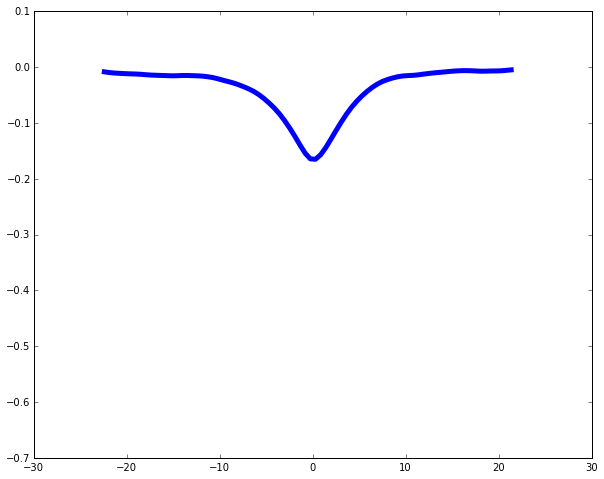

In [221]:
#plot(horz_spatial_pfs[1][0], horz_spatial_pfs[1][1],'g-', linewidth=5)
#plot(horz_spatial_rfs[1][0], horz_spatial_rfs[1][1],'g-', alpha=0.7, linewidth=5)
plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1],'b-', linewidth=5)
#plot(ama_spatial_rfs[0][0], ama_spatial_rfs[0][1], 'b', alpha=0.7, linewidth=5)
ylim([-.7, 0.1])

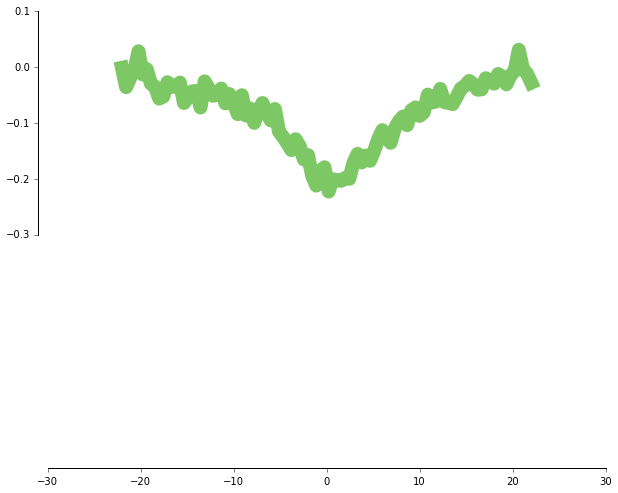

In [239]:
#plot(horz_spatial_pfs[1][0], horz_spatial_pfs[1][1],'g-', linewidth=5)
plot(horz_spatial_rfs[1][0], horz_spatial_rfs[1][1],color='#47B224', alpha=0.7, linewidth=14)
#plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1],'b-', linewidth=5)
#plot(ama_spatial_rfs[0][0], ama_spatial_rfs[0][1], color='#47B224', alpha=0.7, linewidth=14)
ylim([-.7, 0.1])

tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(gca(), ['left', 'bottom'])

In [323]:
inds = (valid_space < -5)

def fitGaussian(xs, stdev, scale):
    gauss = gaussian(x=xs, sigma=stdev, mu=0)
    gauss *= scale
    return gauss

popt, pcov = curve_fit(fitGaussian, valid_space[inds], np.mean(narrow_ganglions, axis=0)[inds], p0=[7., 25.])
ganglion_surround_width = popt[0]

In [326]:
print (popt[0], popt[1])

(5.7637249832166511, 21.486640964299159)


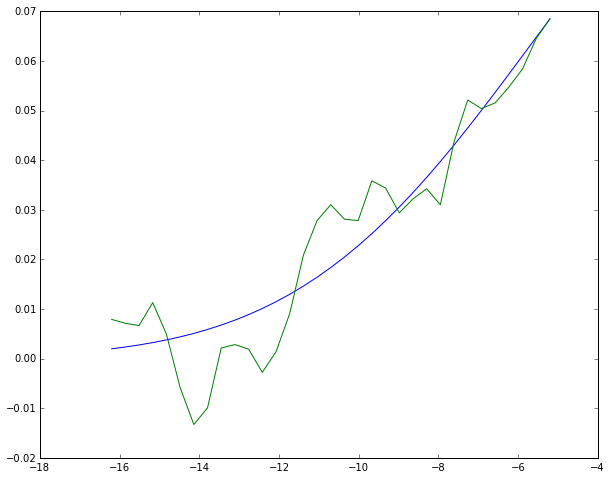

In [325]:
plot(valid_space[inds], fitGaussian(valid_space[inds], popt[0], popt[1]), 'b')
plot(valid_space[inds], np.mean(narrow_ganglions, axis=0)[inds], 'g')

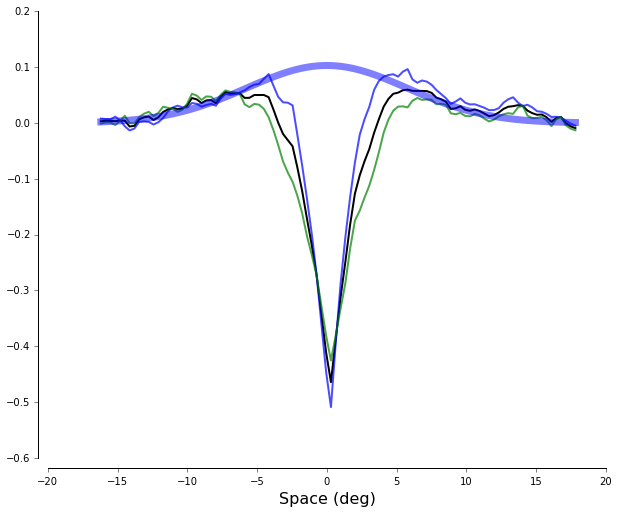

In [327]:
plot(valid_space, np.mean(aligned_ganglion_rfs, axis=0), 'k', linewidth=2)
plot(valid_space, np.mean(narrow_ganglions, axis=0), 'b', alpha=0.7, linewidth=2)
plot(valid_space, np.mean(wide_ganglions, axis=0), 'g', alpha=0.7, linewidth=2)

plot(valid_space, 21.49*gaussian(x=valid_space, sigma=5.76), color='b', linewidth=7, alpha=0.5)
#ylim([-0.5, 0.1])
xlabel('Space (deg)', fontsize=16)
#title('BLK: Average of all ganglion cells, \n BLUE: Average narrow ganglions, \n GRN: Average wide ganglions', fontsize=16)
tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(gca(), ['left', 'bottom'])

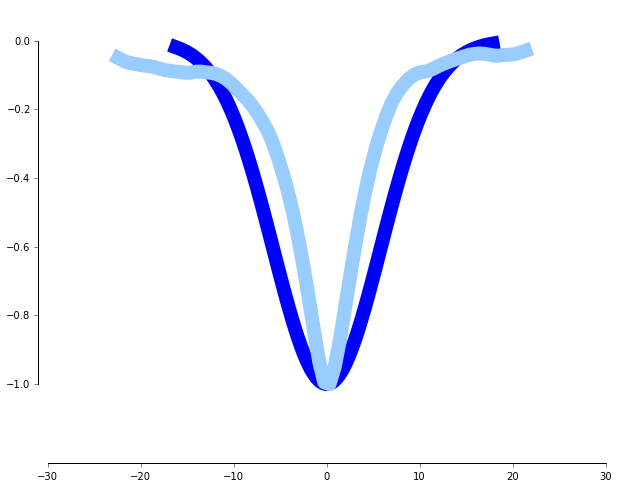

In [342]:
#plot(valid_space, np.mean(aligned_ganglion_rfs, axis=0), 'k', linewidth=2)
#plot(valid_space, np.mean(narrow_ganglions, axis=0), 'b', alpha=0.7, linewidth=2)
#plot(valid_space, np.mean(wide_ganglions, axis=0), 'g', alpha=0.7, linewidth=2)

ganglion_surround = -popt[1]*gaussian(x=valid_space, sigma=popt[0])
horz_surround     = horz_spatial_pfs[1][1] / np.max(abs(horz_spatial_pfs[1][1]))
ama_surround      = ama_spatial_pfs[0][1] / np.max(abs(ama_spatial_pfs[0][1]))

plot(valid_space, ganglion_surround/np.max(abs(ganglion_surround)), color='b', linewidth=14, alpha=1)
#plot(horz_spatial_pfs[1][0], horz_surround,color='#99CCFF', linewidth=14)
plot(ama_spatial_pfs[0][0], ama_surround,color='#99CCFF', linewidth=14)

ylim([-1.2, 0.1])
tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(gca(), ['left', 'bottom'])

## Compare widths of horizontal and amacrine cells by fitting gaussians and comparing their standard deviations

#### Amacrine cell receptive field

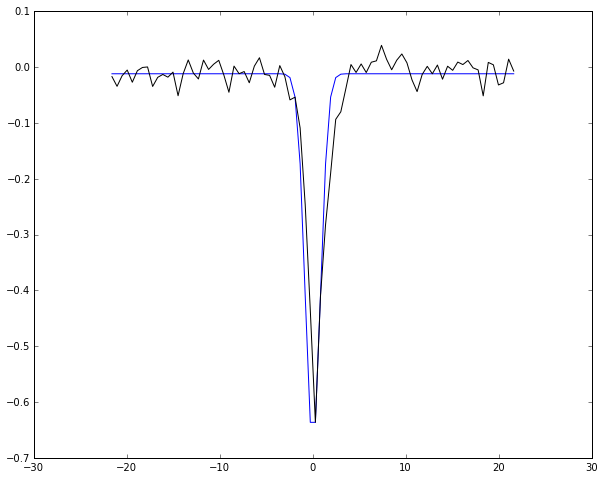

In [10]:
def fitGaussian(xs, stdev, dc, maxi=np.max(abs(ama_spatial_rfs[0][1]))):
    gauss = gaussian(x=xs, sigma=stdev, mu=0) + dc
    gauss *= -maxi/np.max(gauss)
    return gauss

# plot(ama_spatial_pfs[0][0], fitGaussian(ama_spatial_pfs[0][0], 3, 0.001), 'b')
# plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1], 'k')

popt, pcov = curve_fit(fitGaussian, ama_spatial_rfs[0][0], ama_spatial_rfs[0][1], p0=[3, 0.001])
ama_rf_width = popt[0]

plot(ama_spatial_rfs[0][0], fitGaussian(ama_spatial_rfs[0][0], *popt), 'b')
plot(ama_spatial_rfs[0][0], ama_spatial_rfs[0][1], 'k')

#### Amacrine cell projective field

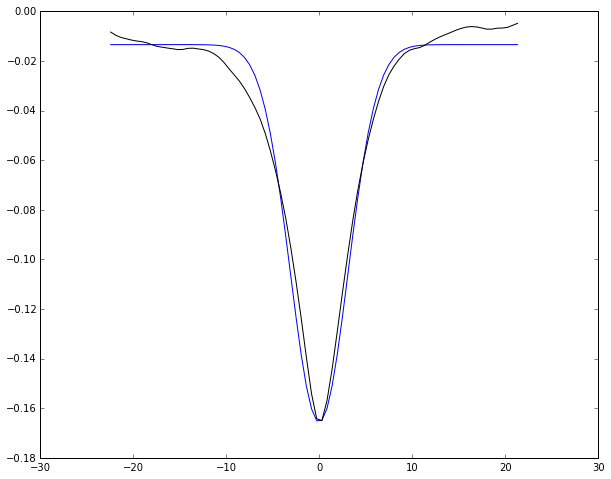

In [11]:
def fitGaussian(xs, stdev, dc, maxi=np.max(abs(ama_spatial_pfs[0][1]))):
    gauss = gaussian(x=xs, sigma=stdev, mu=0) + dc
    gauss *= -maxi/np.max(gauss)
    return gauss

# plot(ama_spatial_pfs[0][0], fitGaussian(ama_spatial_pfs[0][0], 3, 0.001), 'b')
# plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1], 'k')

popt, pcov = curve_fit(fitGaussian, ama_spatial_pfs[0][0], ama_spatial_pfs[0][1], p0=[3, 0.001])
ama_pf_width = popt[0]

plot(ama_spatial_pfs[0][0], fitGaussian(ama_spatial_pfs[0][0], *popt), 'b')
plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1], 'k')

#### Horizontal cell receptive field

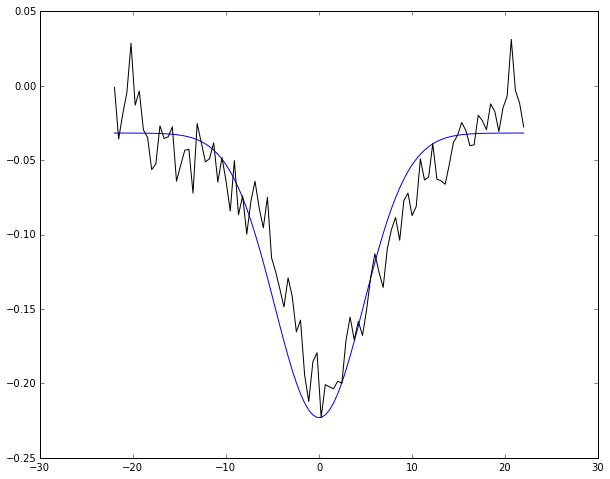

In [12]:
def fitGaussian(xs, stdev, dc, maxi=np.max(abs(horz_spatial_rfs[1][1]))):
    gauss = gaussian(x=xs, sigma=stdev, mu=0) + dc
    gauss *= -maxi/np.max(gauss)
    return gauss

# plot(ama_spatial_pfs[0][0], fitGaussian(ama_spatial_pfs[0][0], 3, 0.001), 'b')
# plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1], 'k')

popt, pcov = curve_fit(fitGaussian, horz_spatial_rfs[1][0], horz_spatial_rfs[1][1], p0=[3, 0.001])
horz_rf_width = popt[0]

plot(horz_spatial_rfs[1][0], fitGaussian(horz_spatial_rfs[1][0], *popt), 'b')
plot(horz_spatial_rfs[1][0], horz_spatial_rfs[1][1], 'k')

#### Horizontal cell projective field

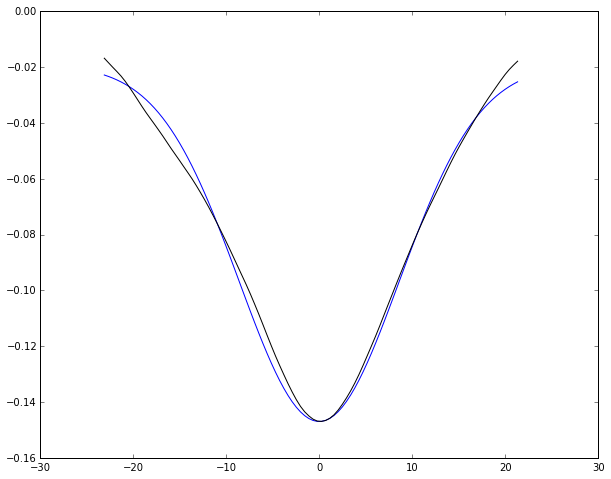

In [13]:
def fitGaussian(xs, stdev, dc, maxi=np.max(abs(horz_spatial_pfs[1][1]))):
    gauss = gaussian(x=xs, sigma=stdev, mu=0) + dc
    gauss *= -maxi/np.max(gauss)
    return gauss

# plot(ama_spatial_pfs[0][0], fitGaussian(ama_spatial_pfs[0][0], 3, 0.001), 'b')
# plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1], 'k')

popt, pcov = curve_fit(fitGaussian, horz_spatial_pfs[1][0], horz_spatial_pfs[1][1], p0=[3, 0.001])
horz_pf_width = popt[0]

plot(horz_spatial_pfs[1][0], fitGaussian(horz_spatial_pfs[1][0], *popt), 'b')
plot(horz_spatial_pfs[1][0], horz_spatial_pfs[1][1], 'k')

## Compare horizontal and amacrine cell widths in receptive and projective fields

In [14]:
horz_rf_width/ama_rf_width

5.8650378759346866

In [15]:
horz_pf_width/ama_pf_width

2.7857469754095034

In [16]:
ama_pf_width

3.089141311069123

# Look at horizontal vs amacrine projective field ffts

In [17]:
horz_spatial_fft = get_horizontal_projective_fft()
ama_spatial_fft  = get_amacrine_projective_fft()

In [18]:
plot(horz_spatial_fft[1][0], horz_spatial_fft[1][1], 'g.-')
plot(ama_spatial_fft[0][0], ama_spatial_fft[0][1], 'c.-')
mpld3.display()

# Look at ganglion cell RFs

In [240]:
ganglion_spatial_rfs = load_ganglion_cells()

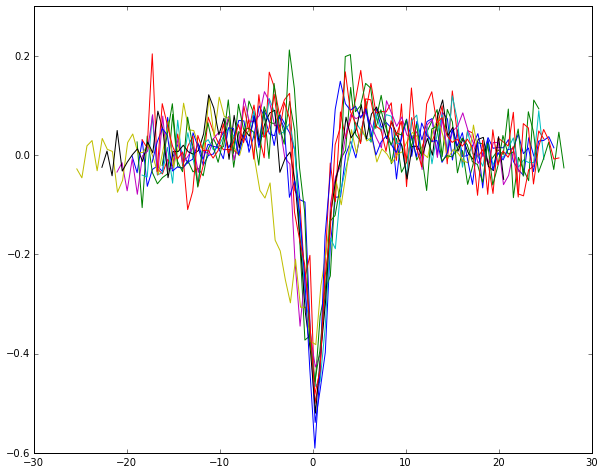

In [241]:
for cell in xrange(10):
    plot(ganglion_spatial_rfs[cell][0], ganglion_spatial_rfs[cell][1])

/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  def asanyarray(a, dtype=None, order=None):


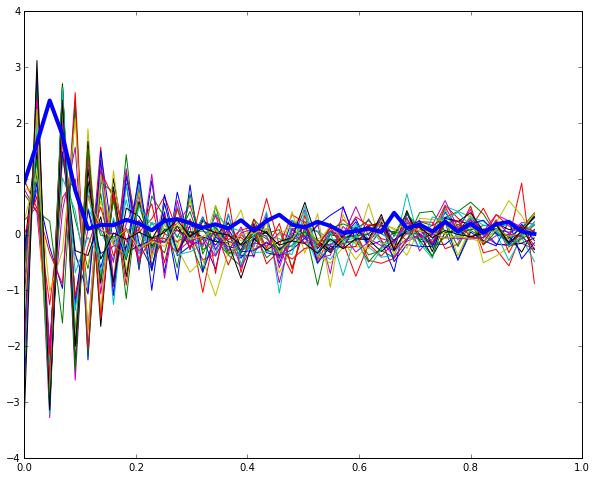

In [242]:
ganglion_ffts = get_fft(ganglion_spatial_rfs, mode='fourier')
for freq, ffti in ganglion_ffts:
    plot(freq, ffti)
plot(freq, abs(np.mean([ffti for _,ffti in ganglion_ffts], axis=0)), linewidth=4)
g_freqs    = freq
g_mean_fft = abs(np.mean([ffti for _,ffti in ganglion_ffts], axis=0))

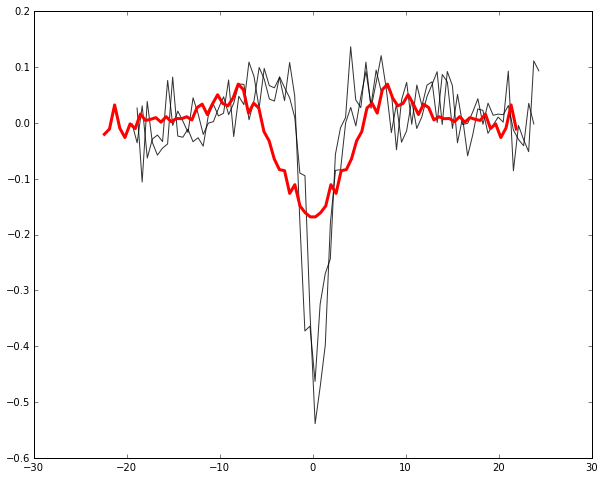

In [243]:
ganglion_rfs = load_ganglion_cells()
spatial_delta = ganglion_rfs[0][0][1] - ganglion_rfs[0][0][0]
plot(ganglion_rfs[0][0], ganglion_rfs[0][1], 'k', linewidth=1, alpha=0.8)
plot(ganglion_rfs[1][0], ganglion_rfs[1][1], 'k', linewidth=1, alpha=0.8)

g_fourier_mean    = np.mean([ffti for _,ffti in ganglion_ffts], axis=0)
g_fourier_mean_2s = np.hstack([g_fourier_mean, g_fourier_mean[1:][::-1]])
figment_ganglion_rf = np.fft.ifft(g_fourier_mean_2s)
figment_ganglion_space = get_space(figment_ganglion_rf, spatial_delta, microns_per_deg=50., scale=False)
plot(figment_ganglion_space, figment_ganglion_rf, 'r', linewidth=3)

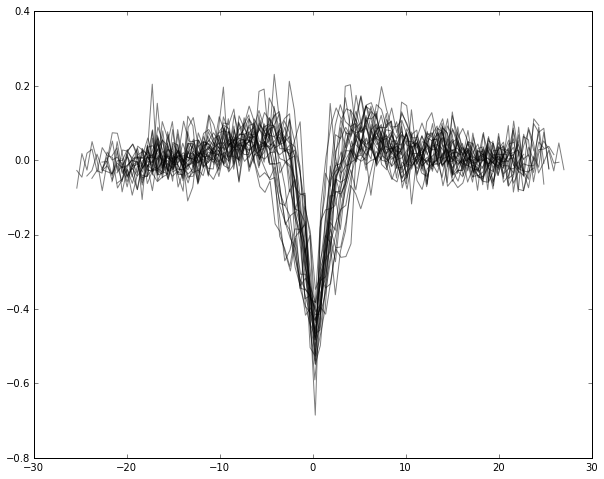

In [244]:
for f, rf in ganglion_rfs:
    plot(f, rf, 'k', alpha=0.5)

## Try clustering according to projection on PCA space

PCA(copy=True, n_components=3, whiten=False)

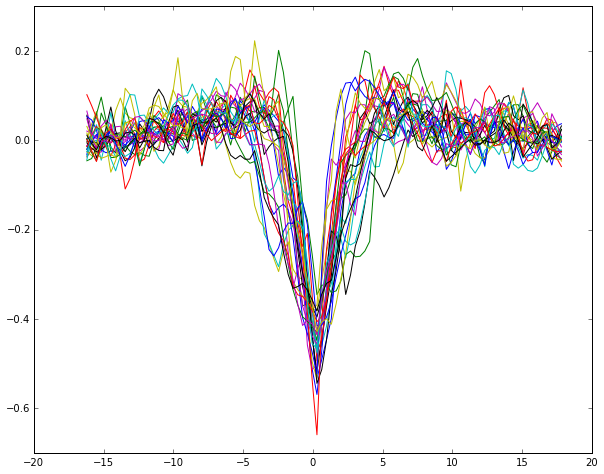

In [245]:
interp_ganglions     = get_interp(ganglion_rfs, nPoints = 100, mode='valid')
aligned_ganglion_rfs = np.vstack([y for x,y in interp_ganglions])
valid_space          = interp_ganglions[0][0]

plot(valid_space, aligned_ganglion_rfs.T)

pca = PCA(n_components=3)
pca.fit(aligned_ganglion_rfs)

In [246]:
pca.explained_variance_

array([ 0.09849361,  0.08718954,  0.03067587])

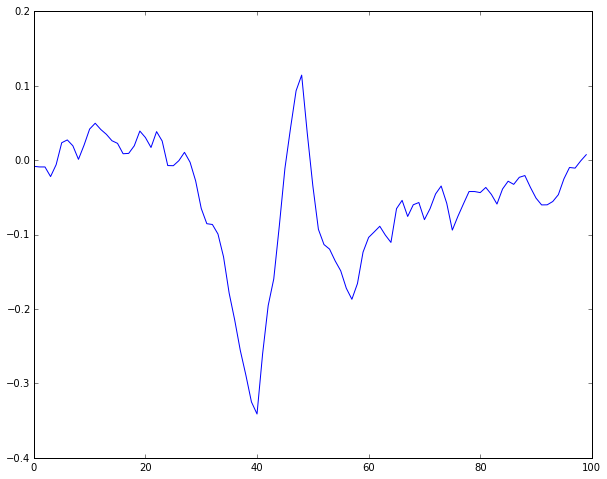

In [247]:
plot(pca.components_[0])

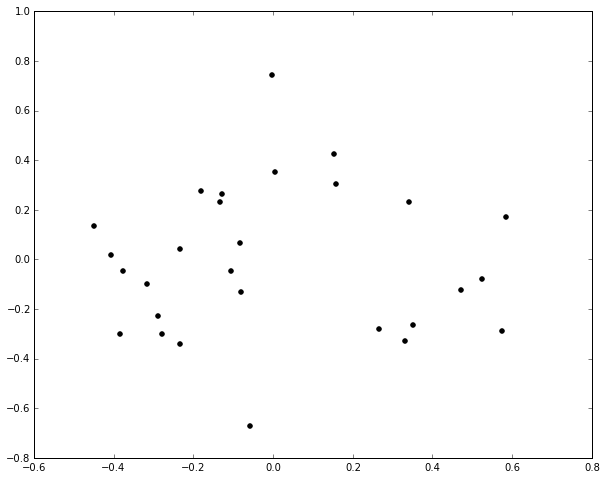

In [248]:
projection_pc1 = np.dot(aligned_ganglion_rfs, pca.components_[0])
projection_pc2 = np.dot(aligned_ganglion_rfs, pca.components_[1])
scatter(projection_pc1, projection_pc2, color='k')

## Cluster ganglion RFs by their width to the first positive number

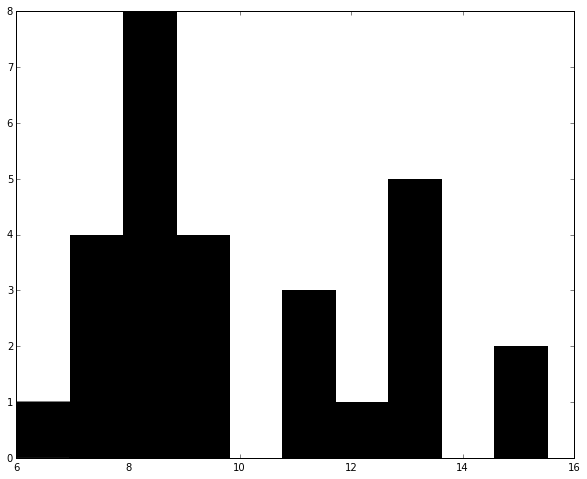

In [249]:
widths = []
for rf in aligned_ganglion_rfs:
    pos_inds = np.array([i for i in xrange(len(rf)) if rf[i] > 0])
    lefties  = 48 - pos_inds
    left_width  = np.min(lefties[lefties>=0])
    right_width = np.min(-lefties[lefties<0])
    #widths.append(np.min(abs(48 - pos_inds)))
    widths.append(np.mean([left_width, right_width]))
counts, bins, _ = hist(widths, color='k')

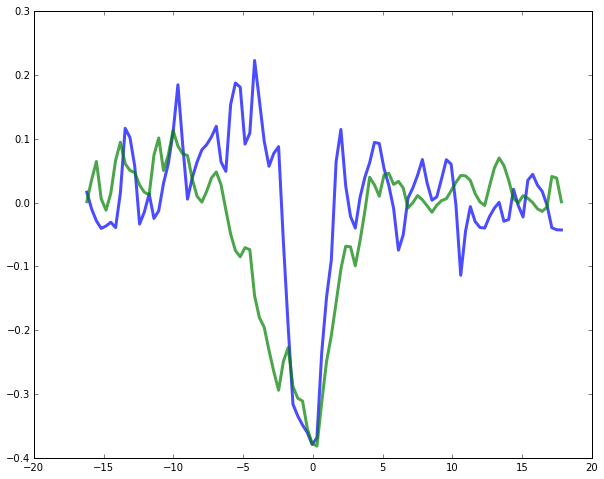

In [250]:
plot(valid_space, aligned_ganglion_rfs[np.argmin(widths)], 'b', linewidth=3, alpha=0.7)
plot(valid_space, aligned_ganglion_rfs[np.argmax(widths)], 'g', linewidth=3, alpha=0.7)

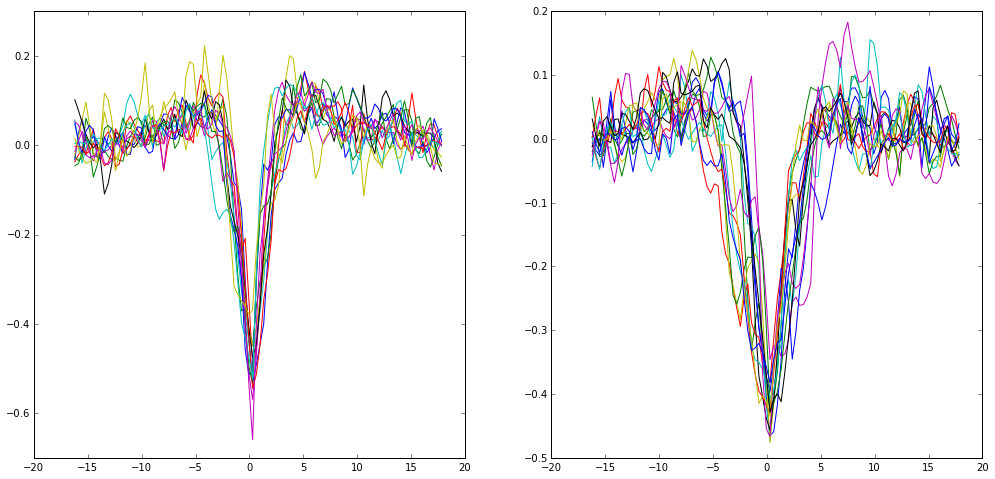

In [251]:
fig = gcf()
fig.set_size_inches((17,8))
subplot(1,2,1)
_ = plot(valid_space, aligned_ganglion_rfs[np.array(widths) < 9].T)
subplot(1,2,2)
_ = plot(valid_space, aligned_ganglion_rfs[np.array(widths) >= 9].T)

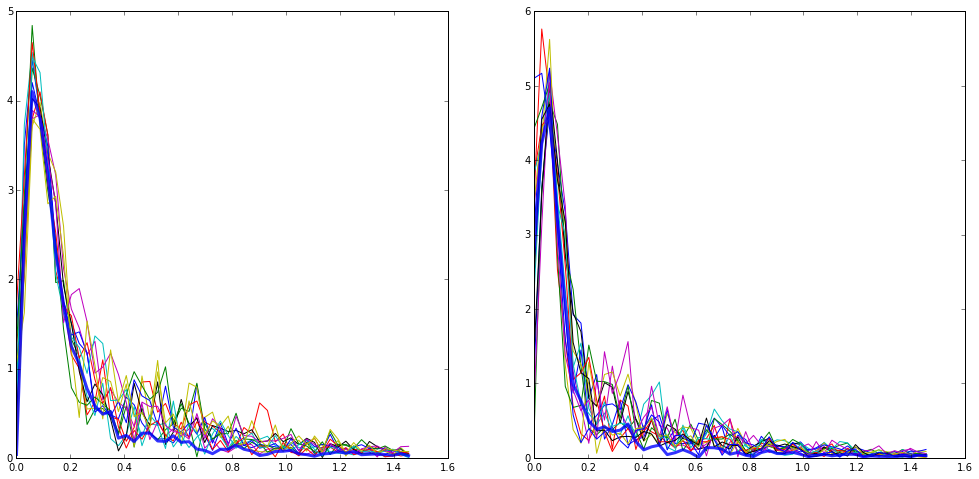

In [252]:
narrow_ganglions = aligned_ganglion_rfs[np.array(widths) < 9]
wide_ganglions   = aligned_ganglion_rfs[np.array(widths) >= 9]
narrow_ganglions_tuples = []
wide_ganglions_tuples   = []
for rf in xrange(narrow_ganglions.shape[0]):
    narrow_ganglions_tuples.append((valid_space, narrow_ganglions[rf]))
for rf in xrange(wide_ganglions.shape[0]):
    wide_ganglions_tuples.append((valid_space, wide_ganglions[rf]))
    
narrow_ganglions_ffts = get_fft(narrow_ganglions_tuples, mode='fourier')
wide_ganglions_ffts   = get_fft(wide_ganglions_tuples, mode='fourier')

fig = gcf()
fig.set_size_inches((17,8))
subplot(1,2,1)
for x,y in narrow_ganglions_ffts:
    plot(x,abs(y))
mean_narrow_ganglion_fft     = np.mean([y for x,y in narrow_ganglions_ffts], axis=0)
mean_narrow_ganglion_fft_err = sem([y for x,y in narrow_ganglions_ffts])
mean_narrow_freqs        = x
plot(x, abs(mean_narrow_ganglion_fft), 'b', linewidth=3, alpha=0.8)
# plot(x, abs(np.mean([abs(y) for x,y in narrow_ganglions_ffts], axis=0)), 'k', linewidth=3, alpha=0.8)
subplot(1,2,2)
for x,y in wide_ganglions_ffts:
    plot(x,abs(y))
mean_wide_ganglion_fft = np.mean([y for x,y in wide_ganglions_ffts], axis=0)
mean_wide_ganglion_fft_err = sem([y for x,y in wide_ganglions_ffts])
mean_wide_freqs        = x
plot(x, abs(mean_wide_ganglion_fft), 'b', linewidth=3, alpha=0.8)
# plot(x, abs(np.mean([abs(y) for x,y in wide_ganglions_ffts], axis=0)), 'k', linewidth=3, alpha=0.8)
#mpld3.display()

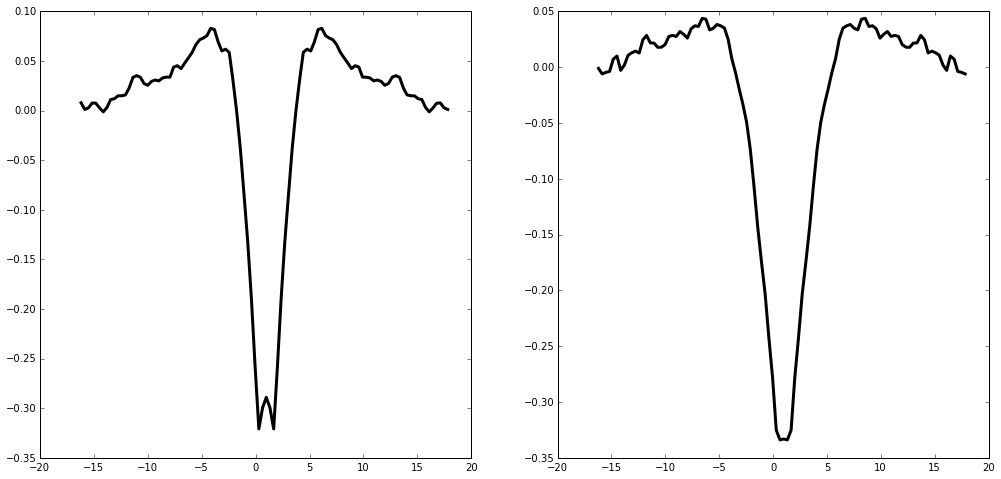

In [253]:
ifft_average_ganglion_narrow = np.fft.ifft(np.hstack([mean_narrow_ganglion_fft, mean_narrow_ganglion_fft[1:-1][::-1]]))
ifft_average_ganglion_wide   = np.fft.ifft(np.hstack([mean_wide_ganglion_fft, mean_wide_ganglion_fft[1:-1][::-1]]))

fig = gcf()
fig.set_size_inches((17,8))
subplot(1,2,1)
plot(valid_space, ifft_average_ganglion_narrow, 'k', linewidth=3)
subplot(1,2,2)
plot(valid_space, ifft_average_ganglion_wide, 'k', linewidth=3)

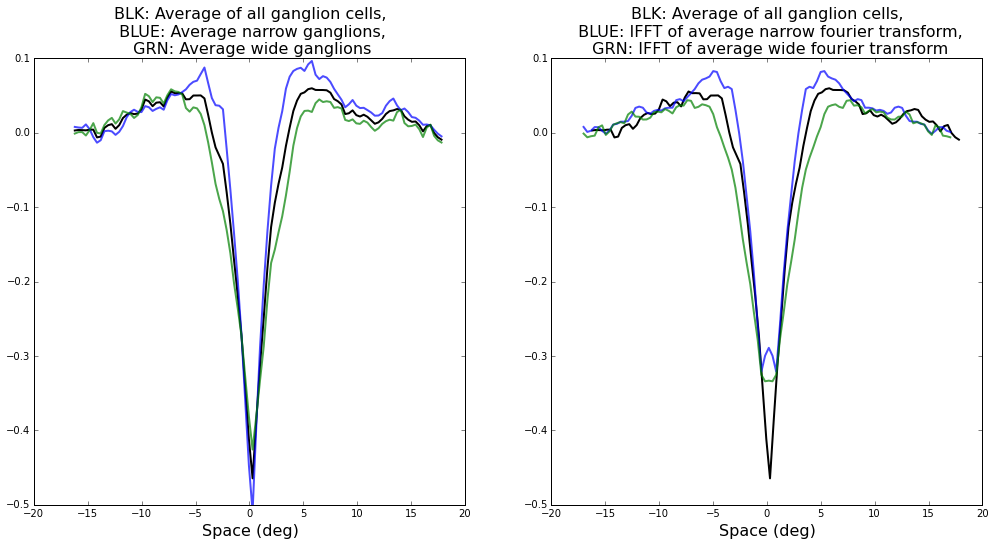

In [256]:
fig = gcf()
fig.set_size_inches((17,8))

subplot(1,2,1)
plot(valid_space, np.mean(aligned_ganglion_rfs, axis=0), 'k', linewidth=2)
plot(valid_space, np.mean(narrow_ganglions, axis=0), 'b', alpha=0.7, linewidth=2)
plot(valid_space, np.mean(wide_ganglions, axis=0), 'g', alpha=0.7, linewidth=2)
ylim([-0.5, 0.1])
xlabel('Space (deg)', fontsize=16)
title('BLK: Average of all ganglion cells, \n BLUE: Average narrow ganglions, \n GRN: Average wide ganglions', fontsize=16)

subplot(1,2,2)
plot(valid_space, np.mean(aligned_ganglion_rfs, axis=0), 'k', linewidth=2)
plot(valid_space-.8, ifft_average_ganglion_narrow, 'b-', alpha=0.7, markersize=10, linewidth=2)
plot(valid_space-.8, ifft_average_ganglion_wide, 'g-', alpha=0.7, markersize=10, linewidth=2)
xlabel('Space (deg)', fontsize=16)
title('BLK: Average of all ganglion cells, \n BLUE: IFFT of average narrow fourier transform, \n GRN: IFFT of average wide fourier transform', fontsize=16)

# Get mean horizontal and amacrine ffts

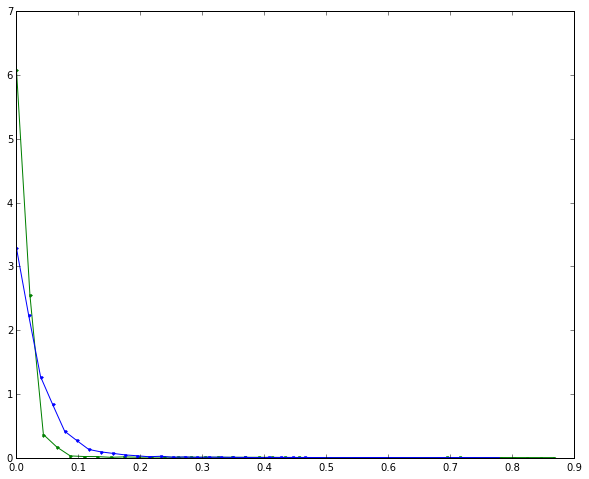

In [255]:
# get raw spatial projective fields
horz_spatial_pfs = get_horizontal_projective_field()
ama_spatial_pfs  = get_amacrine_projective_field()

# align the spatial projective fields
horz_x, horz_mean_pf, horz_err = get_mean(horz_spatial_pfs, nPoints=80)
ama_x, ama_mean_pf, ama_err    = get_mean(ama_spatial_pfs, nPoints=80)

horz_fft = get_fft([(horz_x, horz_mean_pf)], mode='amplitude')
ama_fft  = get_fft([(ama_x, ama_mean_pf)], mode='amplitude')

for freq, ffti in horz_fft:
    plot(freq, ffti, 'g.-')
for freq, ffti in ama_fft:
    plot(freq, ffti, 'b.-')

# Figure 1T Supplemental

# Compare ideal and experimental filters  
Note that even controlling for effective contrast, the magnitude of the images makes a huge difference on what the ideal filter is. This is because it changes the power spectrum by quite a bit, which in turn makes the input and output noise either more or less impactful. TO-DO: Compute true SNR from power spectra.

In [35]:
print 'Effective contrast of example image is %5.2f%%.' %(100.*np.std(patches[0])/np.mean(patches[0]))

Effective contrast of example image is 35.00%.


In [36]:
input_noise  = 0.0002
output_noise = 0.001
np.mean(originalSpectra**2 / (input_noise * originalSpectra**2 + output_noise))

6.2332743126512238

### Actually this is not the true SNR, since we should be dividing by input_noise $\times$ neural_filter, NOT input_noise $\times$ signal

# Look at amplitude spectrum comparison

In [37]:
# get spatial rfs of bipolar and ganglion cells
bipolar_rfs  = load_bipolar_cells()
ganglion_rfs = load_ganglion_cells()

# compute ffts of bipolar and ganglion cells
bipolar_ffts  = get_fft(bipolar_rfs)
ganglion_ffts = get_fft(ganglion_rfs)

# get statistics on the ffts
bipolar_freq, bipolar_mean_fft, bipolar_sem    = get_mean(bipolar_ffts)
ganglion_freq, ganglion_mean_fft, ganglion_sem = get_mean(ganglion_ffts)

# get family of ideal filters
ideal_filts = {}
#input_noises  = np.logspace(-1.,-.42,10)
#output_noises = np.logspace(-.65,-.4,10)
# input_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
# output_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
input_noises = [0.085] #[0.12]
output_noises = [0.35] #[0.35]

moreFreqs, moreSpectra = spectrum_fit(originalFreqs, originalSpectra)
for N in input_noises:
    for N_del in output_noises:
        ideal_filts[(N,N_del)] = unique_soln(moreSpectra**2, N, N_del, verbose=False)

(0.085, 0.35)


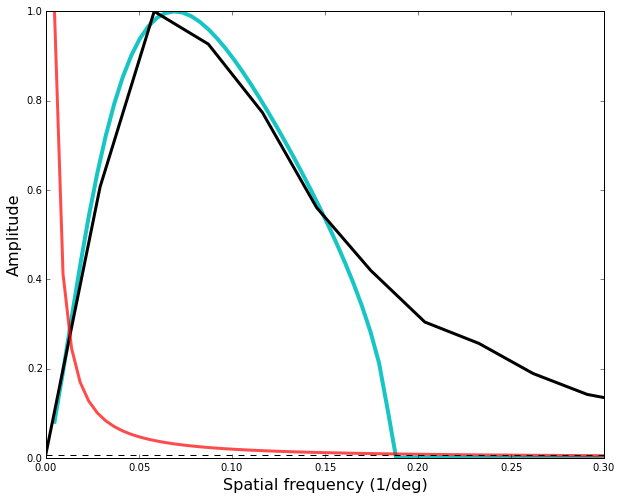

In [38]:
for k in ideal_filts.keys():
    plot(moreFreqs, (ideal_filts[k]/np.nanmax(ideal_filts[k])), 'c', alpha=0.9, linewidth=4) # alpha=0.6
    print k


g_max = np.nanmax(abs(mean_narrow_ganglion_fft))
plot(mean_narrow_freqs, abs(mean_narrow_ganglion_fft)/g_max, 'k', alpha=1., linewidth=3)
#errorbar(ganglion_freq, ganglion_mean_fft/g_max, yerr=(1./g_max)*ganglion_sem, color='k', alpha=0.7)

def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

numPoints=5000
popt, pcov  = curve_fit(func, originalFreqs[1:], originalSpectra[1:])
moreFreqs   = np.linspace(0., originalFreqs[-1], numPoints)[1:]
moreSpectra = func(moreFreqs, *popt)

plot(moreFreqs, (moreSpectra/np.nanmax(moreSpectra)), 'r', linewidth=3, alpha=0.7)
plot(originalFreqs, 0.085**2 *np.ones(len(originalFreqs)), 'k--')

ylabel('Amplitude', fontsize=16)
xlabel('Spatial frequency (1/deg)', fontsize=16)
xlim([0,.3])

# savefig('Figures/' + str(ideal_filts.keys()[n]) + '.png')
savefig('Figures/' + str(ideal_filts[k]) + '.png')
#     plt.close()
#     pause(2)
    #ylim([0,4])
    #mpld3.display()

# Look at power spectrum; why does power spectrum of infomax match the amplitude spectrum of ganglion cells better?

In [39]:
# get spatial rfs of bipolar and ganglion cells
bipolar_rfs  = load_bipolar_cells()
ganglion_rfs = load_ganglion_cells()

# compute ffts of bipolar and ganglion cells
bipolar_ffts  = get_fft(bipolar_rfs)
ganglion_ffts = get_fft(ganglion_rfs)

# get statistics on the ffts
bipolar_freq, bipolar_mean_fft, bipolar_sem    = get_mean(bipolar_ffts)
ganglion_freq, ganglion_mean_fft, ganglion_sem = get_mean(ganglion_ffts)

# get family of ideal filters
ideal_filts = {}
#input_noises  = np.logspace(-1.,-.42,10)
#output_noises = np.logspace(-.65,-.4,10)
# input_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
# output_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
input_noises = [0.11] #[0.085] #[0.12]
output_noises = [0.09] #[0.35] #[0.35]

moreFreqs, moreSpectra = spectrum_fit(originalFreqs, originalSpectra)
for N in input_noises:
    for N_del in output_noises:
        ideal_filts[(N,N_del)] = unique_soln(moreSpectra**2, N, N_del, verbose=False)

(0.11, 0.09)


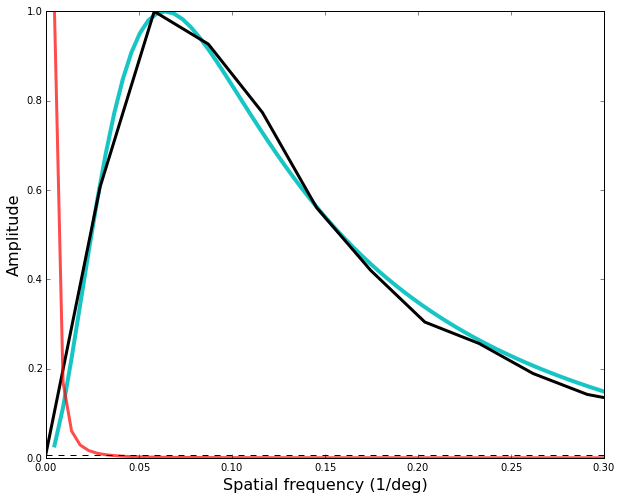

In [40]:
for k in ideal_filts.keys():
    plot(moreFreqs, (ideal_filts[k]/np.nanmax(ideal_filts[k]))**2, 'c', alpha=0.9, linewidth=4) # alpha=0.6
    print k


g_max = np.nanmax(abs(mean_narrow_ganglion_fft))
plot(mean_narrow_freqs, abs(mean_narrow_ganglion_fft)/g_max, 'k', alpha=1., linewidth=3)
#errorbar(ganglion_freq, ganglion_mean_fft/g_max, yerr=(1./g_max)*ganglion_sem, color='k', alpha=0.7)

def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

numPoints=5000
popt, pcov  = curve_fit(func, originalFreqs[1:], originalSpectra[1:])
moreFreqs   = np.linspace(0., originalFreqs[-1], numPoints)[1:]
moreSpectra = func(moreFreqs, *popt)

plot(moreFreqs, (moreSpectra/np.nanmax(moreSpectra))**2, 'r', linewidth=3, alpha=0.7)
plot(originalFreqs, 0.085**2 *np.ones(len(originalFreqs)), 'k--')

ylabel('Amplitude', fontsize=16)
xlabel('Spatial frequency (1/deg)', fontsize=16)
xlim([0,.3])

# savefig('Figures/' + str(ideal_filts.keys()[n]) + '.png')
savefig('Figures/' + str(ideal_filts[k]) + '.png')
#     plt.close()
#     pause(2)
    #ylim([0,4])
    #mpld3.display()

# Correct power vs power

In [39]:
# get spatial rfs of bipolar and ganglion cells
bipolar_rfs  = load_bipolar_cells()
ganglion_rfs = load_ganglion_cells()

# compute ffts of bipolar and ganglion cells
bipolar_ffts  = get_fft(bipolar_rfs)
ganglion_ffts = get_fft(ganglion_rfs)

# get statistics on the ffts
bipolar_freq, bipolar_mean_fft, bipolar_sem    = get_mean(bipolar_ffts)
ganglion_freq, ganglion_mean_fft, ganglion_sem = get_mean(ganglion_ffts)

# get family of ideal filters
ideal_filts = {}
#input_noises  = np.logspace(-1.,-.42,10)
#output_noises = np.logspace(-.65,-.4,10)
# input_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
# output_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
input_noises = [0.09] #[0.085] #[0.12]
output_noises = [0.35] #[0.35] #[0.35]

moreFreqs, moreSpectra = spectrum_fit(originalFreqs, originalSpectra)
for N in input_noises:
    for N_del in output_noises:
        ideal_filts[(N,N_del)] = unique_soln(moreSpectra**2, N, N_del, verbose=False)

In [234]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

(0.09, 0.35)


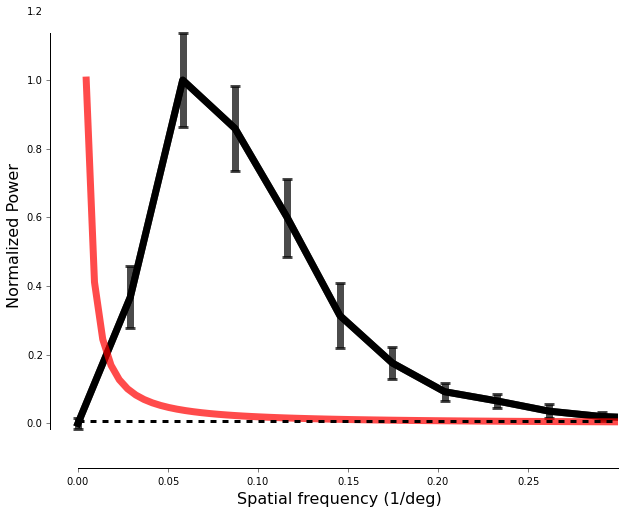

In [50]:
g_max = np.nanmax(abs(mean_narrow_ganglion_fft))
plot(mean_narrow_freqs, (abs(mean_narrow_ganglion_fft)/g_max)**2, 'k', alpha=1., linewidth=7)
narrow_ganglion_fft_errs = sem([(y/g_max)**2 for x, y in narrow_ganglions_ffts])
errorbar(mean_narrow_freqs, (abs(mean_narrow_ganglion_fft)/g_max)**2, yerr=narrow_ganglion_fft_errs, color='k', alpha=0.7, linewidth=7, capthick=3, capsize=5)

for k in ideal_filts.keys():
    #plot(moreFreqs, (ideal_filts[k]/np.nanmax(ideal_filts[k]))**2, color='#6699ff', alpha=0.7, linewidth=7) # alpha=0.6
    print k

def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

numPoints=5000
popt, pcov  = curve_fit(func, originalFreqs[1:], originalSpectra[1:])
moreFreqs   = np.linspace(0., originalFreqs[-1], numPoints)[1:]
moreSpectra = func(moreFreqs, *popt)

plot(moreFreqs, (moreSpectra/np.nanmax(moreSpectra)), 'r', linewidth=7, alpha=0.7)
plot(originalFreqs, (0.085**2 *np.ones(len(originalFreqs))), 'k--', linewidth=3)

ylabel('Normalized Power', fontsize=16)
xlabel('Spatial frequency (1/deg)', fontsize=16)
xlim([-.01,.3])
ylim([-.1, 1.2])

tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(gca(), ['left', 'bottom'])

# savefig('Figures/' + str(ideal_filts.keys()[n]) + '.png')
#savefig('Figures/' + str(ideal_filts[k]) + '.png')
#     plt.close()
#     pause(2)
    #ylim([0,4])
    #mpld3.display()

In [42]:
test1 = [-i*np.sign(2*(idx % 2) - 1) for idx,i in enumerate(ideal_filts[k])]
test2 = [i for i in ideal_filts[k]]

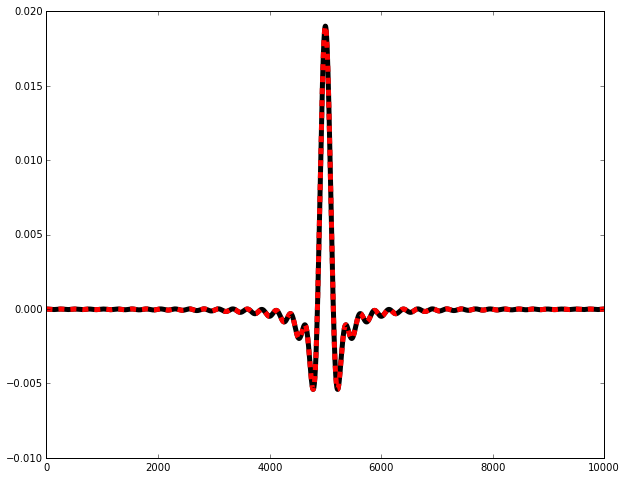

In [43]:
plot(np.fft.ifft(np.hstack([test1, test1[1:][::-1]])), 'k', linewidth=5)
plot(np.fft.fftshift(np.fft.ifft(np.hstack([test2, test2[1:][::-1]]))), 'r--', linewidth=5)

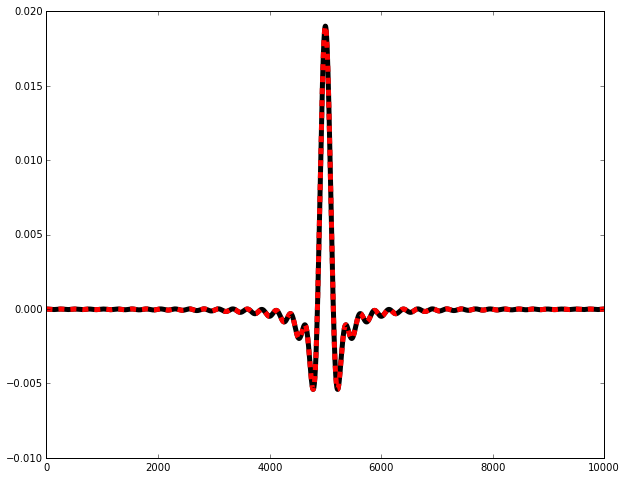

In [44]:
plot(np.fft.ifft(np.hstack([test1, test1[1:][::-1]])), 'k', linewidth=5)
plot(np.fft.fftshift(np.fft.ifft(np.hstack([test2, test2[1:][::-1]]))), 'r--', linewidth=5)

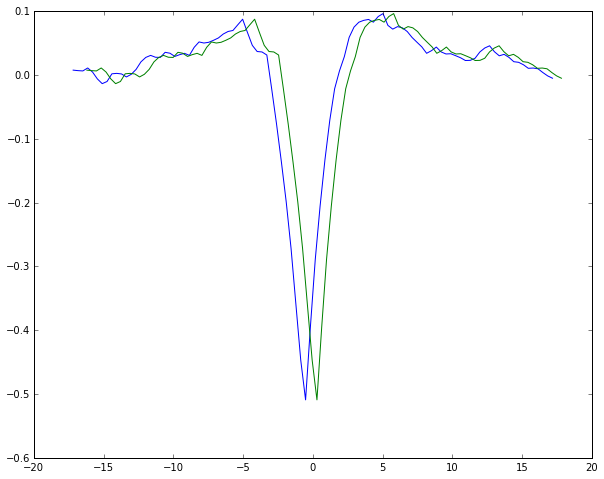

In [45]:
# spacing_valid = valid_space[-1] - valid_space[-2]
spacing_valid = 1./(2*mean_narrow_freqs[-1])
n = len(valid_space)
symm_spacing = np.linspace(-spacing_valid*(n/2),spacing_valid*(n/2),n)

plot(symm_spacing, np.mean(narrow_ganglions, axis=0))
plot(valid_space, np.mean(narrow_ganglions, axis=0), 'g')

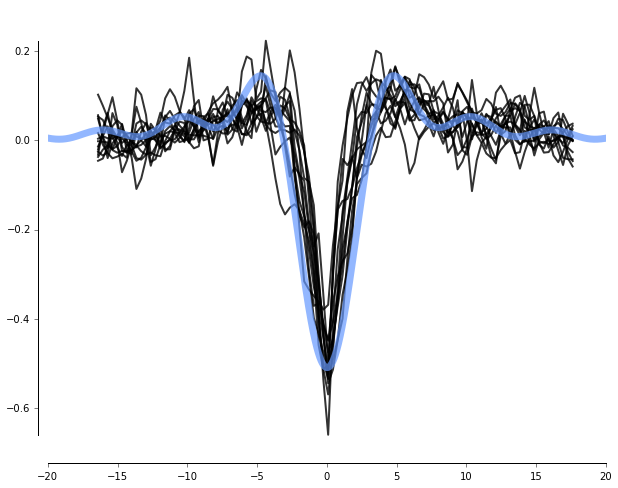

In [46]:
# Experimental
#plot(valid_space, np.mean(narrow_ganglions, axis=0), color='k', alpha=0.8, linewidth=7)
plot(valid_space-.2, narrow_ganglions.T, color='k', alpha=0.8, linewidth=2)
#errorbar(valid_space-.2, np.mean(narrow_ganglions, axis=0), yerr=sem(narrow_ganglions), color='k', alpha=0.7, linewidth=7, capthick=3, capsize=5)

# IDEAL
spacing_ideal = 1./(2*moreFreqs[-1])
filter_ideal  = np.fft.ifftshift(np.fft.ifft(np.hstack([ideal_filts[k], ideal_filts[k][1:][::-1]])))
n             = len(filter_ideal)
filter_x      = np.linspace(-spacing_ideal*n/2., spacing_ideal*n/2., n)
filter_ideal *= -(np.max(abs(np.mean(narrow_ganglions, axis=0)))/np.max(abs(filter_ideal)))
plot(filter_x, filter_ideal, color='#6699ff', alpha=0.7, linewidth=7)
xlim([-20,20])

tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(gca(), ['left', 'bottom'])

# Figure 1T

## scaling difference comes from 'valid' versus 'full' methods of interpolating/averaging

The relative error from this choice of Lagrangian multiplier is 1.0099886807e-07.


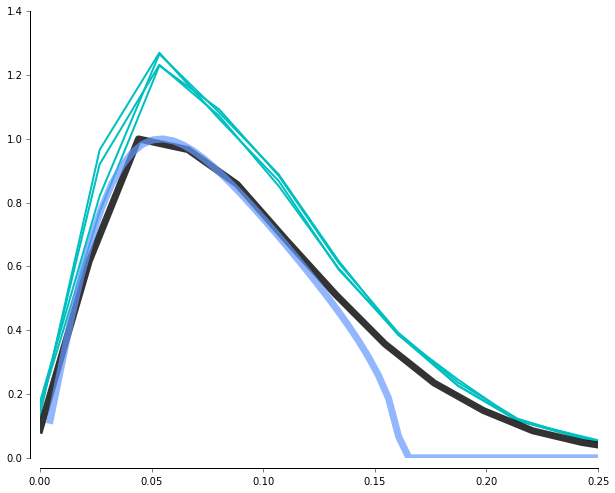

In [81]:
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=.5, ama_weighting=0.75,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[0,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate')

The relative error from this choice of Lagrangian multiplier is 2.91702143869e-08.


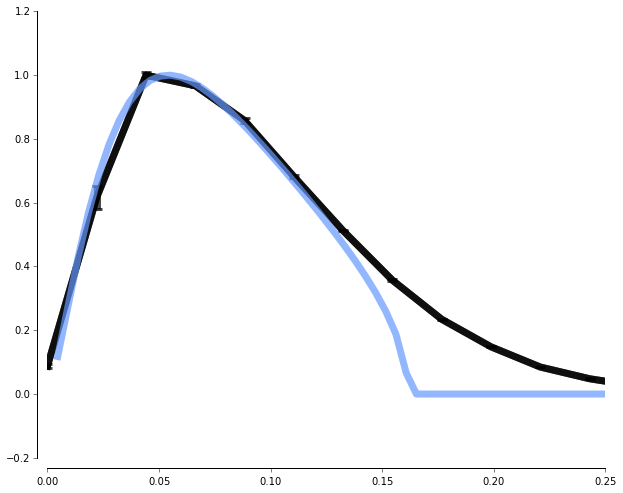

In [83]:
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=.5, ama_weighting=0.75,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[0,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate')

The relative error from this choice of Lagrangian multiplier is 1.04909793312e-07.


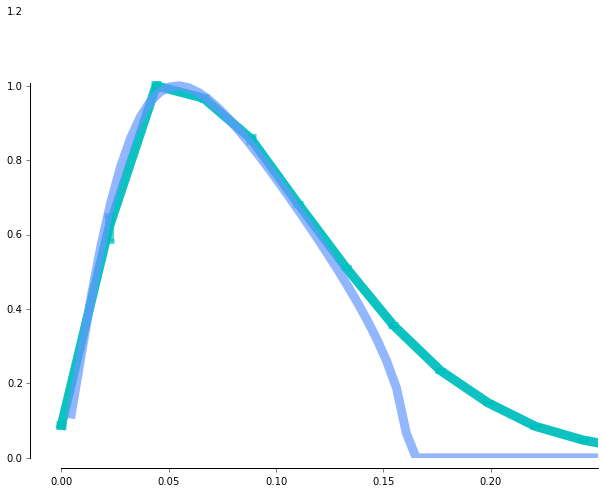

In [259]:
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=.5, ama_weighting=0.75,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate')

The relative error from this choice of Lagrangian multiplier is 8.42110540901e-08.


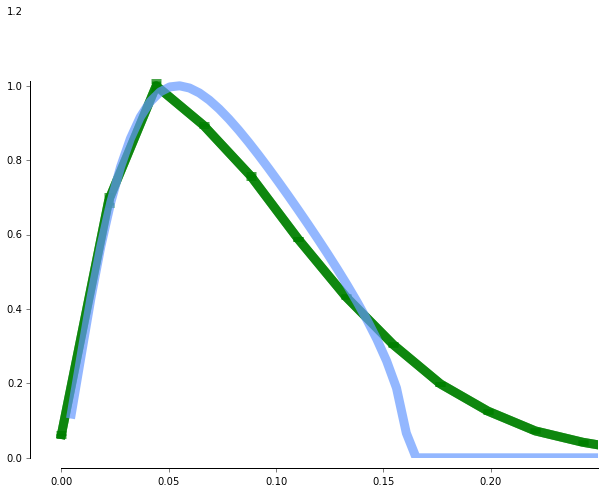

In [266]:
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=.85, ama_weighting=0.,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate',
                                                                     aggregateColor='g')

The relative error from this choice of Lagrangian multiplier is 2.77373476049e-07.


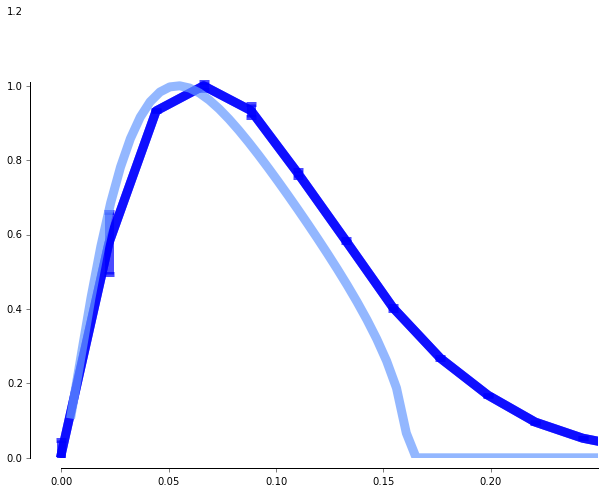

In [263]:
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=0., ama_weighting=1.5,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate',
                                                                     aggregateColor='b')

# Fitting many ganglion cells

The relative error from this choice of Lagrangian multiplier is 2.54585604433e-07.


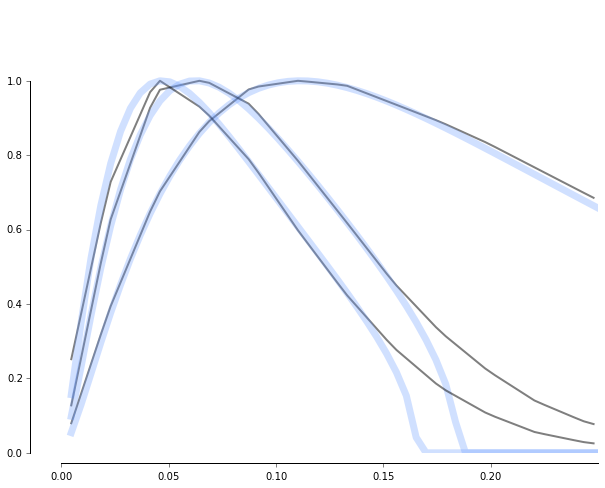

In [163]:
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=.1, ama_weighting=1.3,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='many')
#mpld3.display()

The relative error from this choice of Lagrangian multiplier is 1.96608610691e-07.


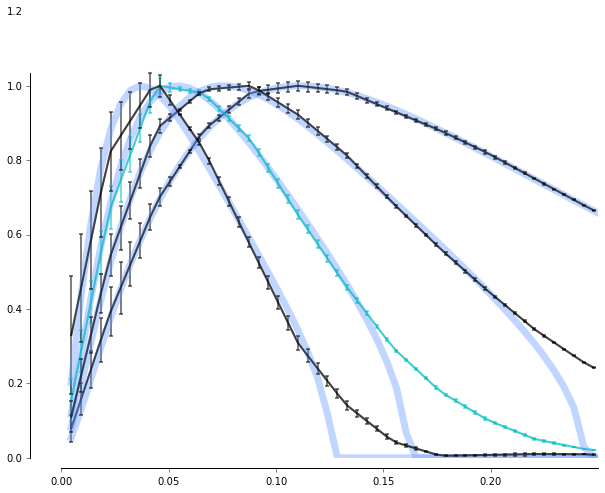

In [197]:
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=.1, ama_weighting=1.3,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='many')
#mpld3.display()

The relative error from this choice of Lagrangian multiplier is 1.64357466981e-08.


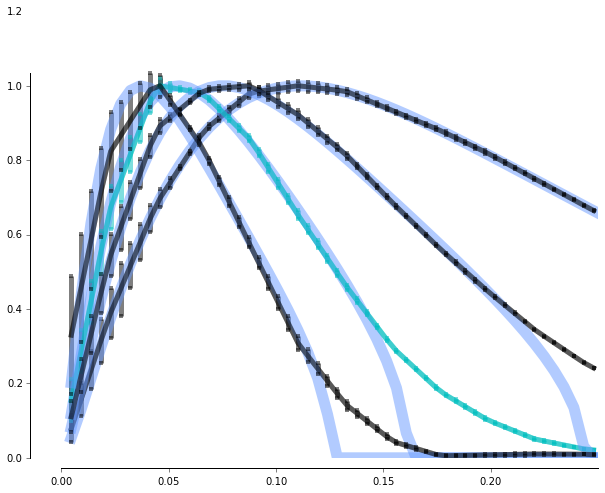

In [200]:
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=.1, ama_weighting=1.3,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='many')
#mpld3.display()

# Revising Fig 1T (horz and ama only) with function calls to 'horizontalOnly' and 'amacrineOnly' flags

The relative error from this choice of Lagrangian multiplier is 2.75718983483e-07.


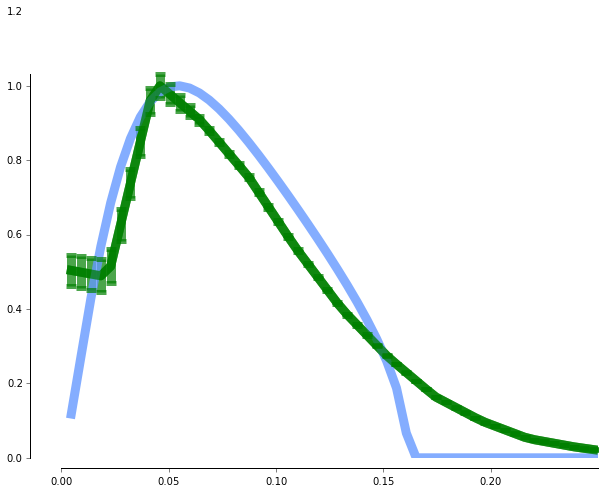

In [255]:
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='horizontalOnly')

The relative error from this choice of Lagrangian multiplier is 5.20616597413e-08.


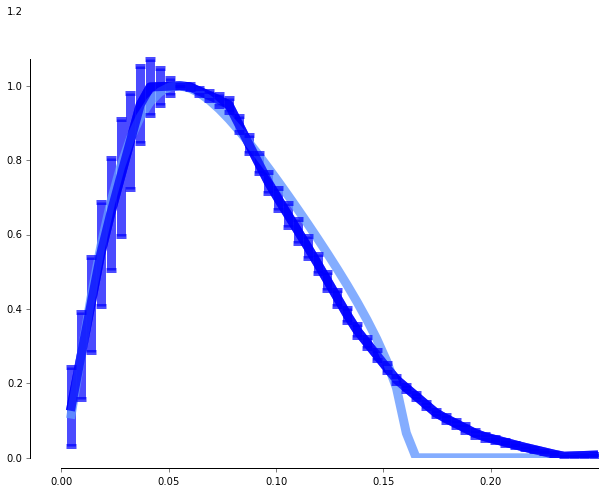

In [258]:
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='amacrineOnly')

# If I wanted to fix the center width, what would it be? Let's find out via fitting a difference of Gaussians to narrow ganglion cells

In [285]:
def diff_gaussians(xs, center_width, surround_width, surround_scale):
    center_surround = -gaussian(x=xs, sigma=center_width) + surround_scale * gaussian(x=xs, sigma=surround_width)
    return center_surround/np.max(abs(center_surround))

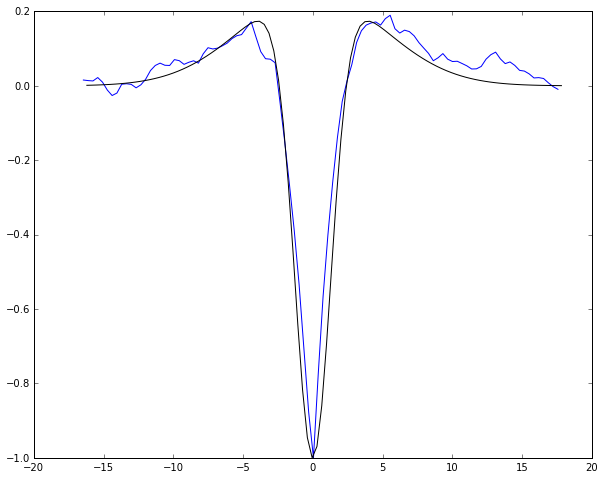

In [320]:
mean_narrow_ganglion = np.mean(narrow_ganglions, axis=0)
plot(valid_space-.25, mean_narrow_ganglion/np.max(abs(mean_narrow_ganglion)))
plot(valid_space, diff_gaussians(valid_space, 1.3, 5, 3), 'k')
#plot(valid_space, gaussian(x=valid_space))

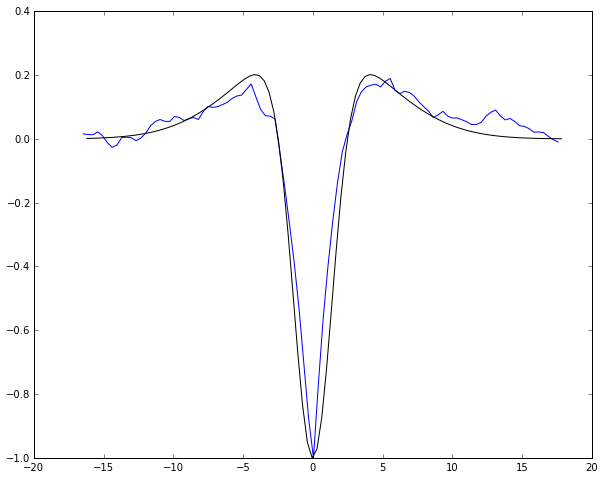

In [337]:
mean_narrow_ganglion = np.mean(narrow_ganglions, axis=0)
plot(valid_space-.25, mean_narrow_ganglion/np.max(abs(mean_narrow_ganglion)))
plot(valid_space, diff_gaussians(valid_space, 1.4, 5, 3), 'k')
#plot(valid_space, gaussian(x=valid_space))

In [318]:
aligned_space = valid_space - .25
#aligned_mean_narrow_ganglion = interp1d(aligned_space, mean_narrow_ganglion/np.max(abs(mean_narrow_ganglion)))
popt, pcov = curve_fit(diff_gaussians, aligned_space, mean_narrow_ganglion, p0=[1.3, 5., 3.])

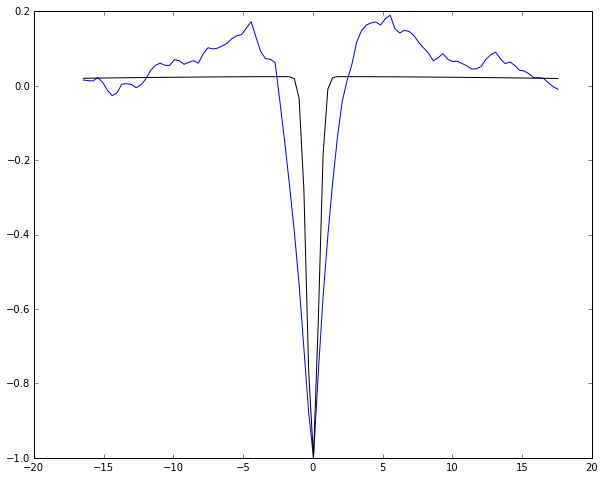

In [319]:
plot(aligned_space, mean_narrow_ganglion/np.max(abs(mean_narrow_ganglion)))
plot(aligned_space, diff_gaussians(aligned_space, *popt), 'k')

## all ganglions?

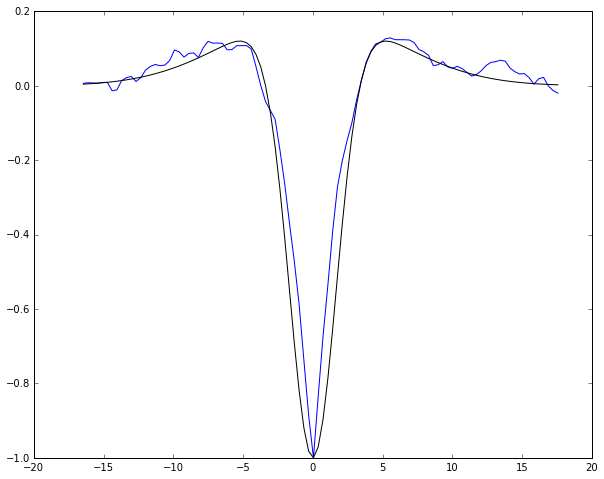

In [346]:
mean_ganglion = np.mean(aligned_ganglion_rfs, axis=0)
plot(aligned_space, mean_ganglion/np.max(abs(mean_ganglion)))
plot(aligned_space, diff_gaussians(aligned_space, 1.7, 6, 2.), 'k')
#plot(valid_space, gaussian(x=valid_space))

# now we know that the center measurement is reliable, how well do amacrine and horizontal cells fare with a fixed center width?

The relative error from this choice of Lagrangian multiplier is 8.77469957571e-08.


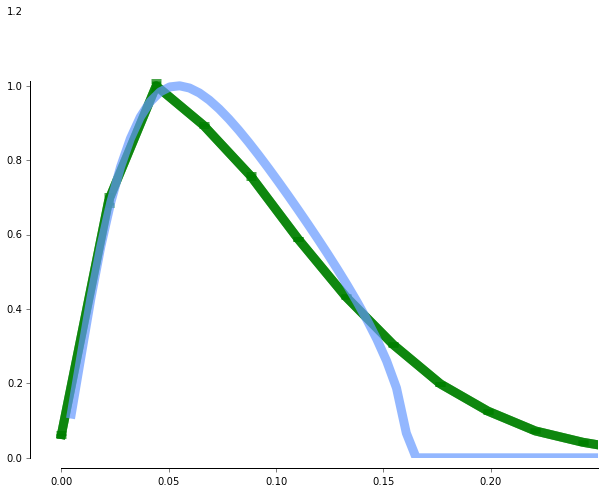

In [185]:
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h, h_freqs, h_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=.85, ama_weighting=0.,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate',
                                                                     aggregateColor='g', statistics=True)

The relative error from this choice of Lagrangian multiplier is 1.26334613642e-07.


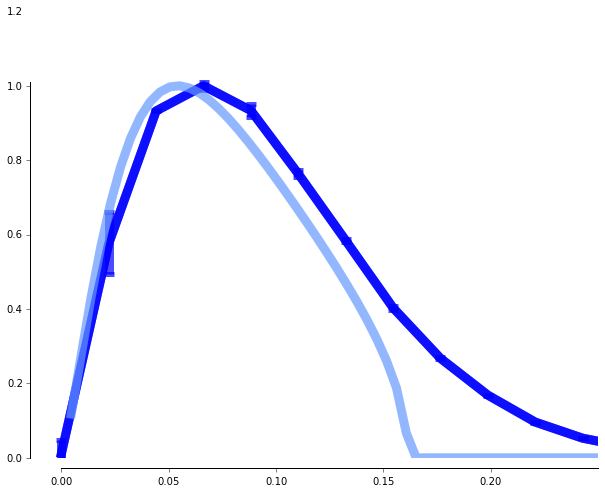

In [186]:
freq_ideal, filt_ideal, freq_expt_a, filt_expt_a, a_freqs, a_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=0., ama_weighting=1.5,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate',
                                                                     aggregateColor='b', statistics=True)

The relative error from this choice of Lagrangian multiplier is 8.69671167853e-08.


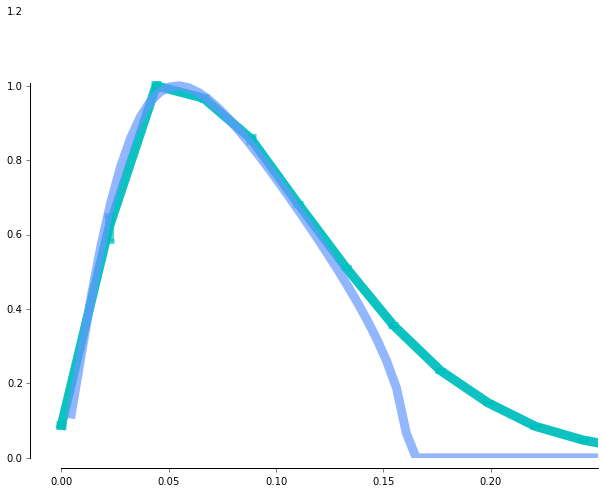

In [386]:
freq_ideal, filt_ideal, freq_expt_both, filt_expt_both = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=.5, ama_weighting=0.75,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate')

# Quantify mean squared error between experiment and ideal

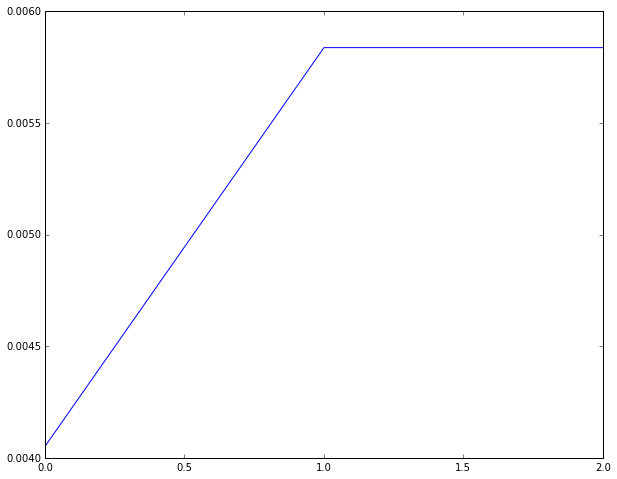

In [383]:
# interpolate to get experiment and ideal on same page
min_f       = np.max([np.min(freq_ideal), np.min(freq_expt_both), np.min(freq_expt_a), np.min(freq_expt_h)])
max_f       = np.min([np.max(freq_ideal), np.max(freq_expt_both), np.max(freq_expt_a), np.max(freq_expt_h)])
valid_freqs = np.linspace(min_f, max_f, 10)

h_filt = interp1d(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h))
a_filt = interp1d(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a))
b_filt = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both))
t_filt = interp1d(freq_ideal, filt_ideal/np.nanmax(filt_ideal))

test_freqs = np.linspace(min_f, 0.12, 100)

h_errors = np.mean((h_filt(test_freqs) - t_filt(test_freqs))**2)
a_errors = np.mean((a_filt(test_freqs) - t_filt(test_freqs))**2)
b_errors = np.mean((a_filt(test_freqs) - t_filt(test_freqs))**2)
errors = [h_errors, a_errors, b_errors]
plot(errors)

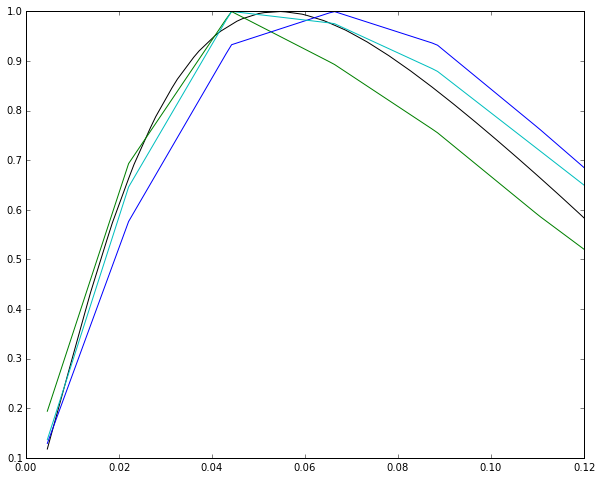

In [384]:
plot(test_freqs, t_filt(test_freqs), 'k')
plot(test_freqs, h_filt(test_freqs), 'g')
plot(test_freqs, a_filt(test_freqs), 'b')
plot(test_freqs, b_filt(test_freqs), 'c')


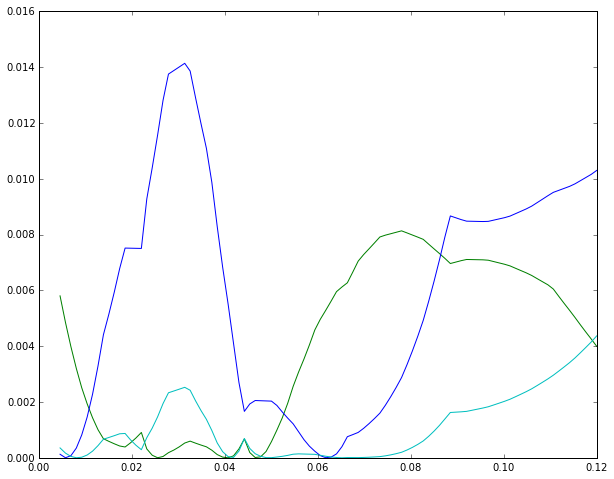

In [385]:
plot(test_freqs, abs(t_filt(test_freqs) - h_filt(test_freqs))**2, 'g')
plot(test_freqs, abs(t_filt(test_freqs) - a_filt(test_freqs))**2, 'b')
plot(test_freqs, abs(t_filt(test_freqs) - b_filt(test_freqs))**2, 'c')

In [388]:
horz_weighting, ama_weighting, center_weighting, surround_weighting, center_width = [0.22308377,  1.1650738 ,  7.78441117,  0.50850956,  1.86945477]

[0.22308377, 1.1650738, 7.78441117, 0.50850956, 1.86945477]

The relative error from this choice of Lagrangian multiplier is 3.22906519224e-07.


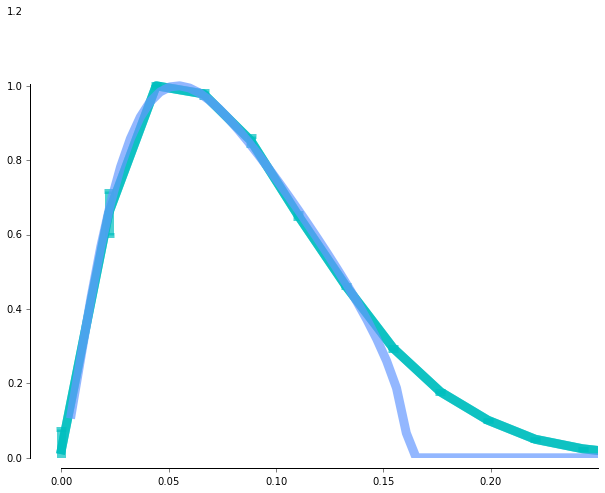

In [72]:
freq_ideal, filt_ideal, freq_expt_both, filt_expt_both, both_freqs, both_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=7.7844, surround_weighting=.5085,
                                                                     horz_weighting=.223, ama_weighting=1.165,
                                                                     center_width=1.86945,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate',
                                                                                       statistics=True)

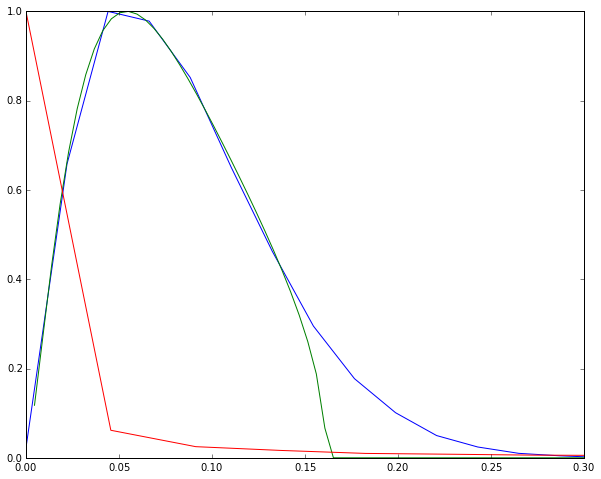

In [84]:
plot(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both))
plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal))
xlim([0,0.3])
plot(originalFreqs, originalSpectra/np.nanmax(originalSpectra))

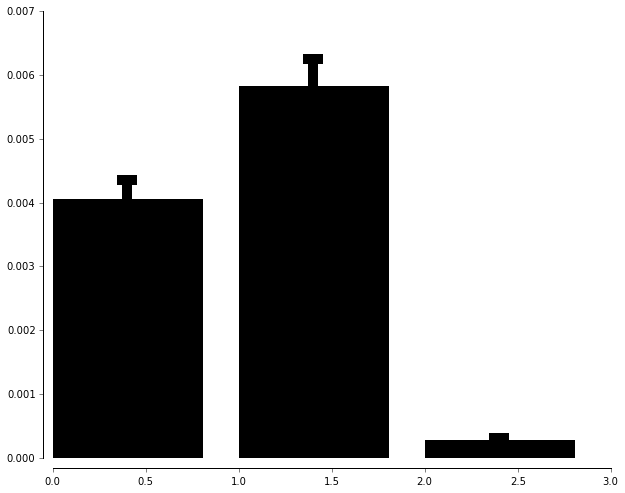

In [413]:
# interpolate to get experiment and ideal on same page
min_f       = np.max([np.min(freq_ideal), np.min(freq_expt_both), np.min(freq_expt_a), np.min(freq_expt_h)])
max_f       = np.min([np.max(freq_ideal), np.max(freq_expt_both), np.max(freq_expt_a), np.max(freq_expt_h)])
valid_freqs = np.linspace(min_f, max_f, 10)

h_filt = interp1d(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h))
a_filt = interp1d(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a))
b_filt = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both))
t_filt = interp1d(freq_ideal, filt_ideal/np.nanmax(filt_ideal))

test_freqs = np.linspace(min_f, 0.12, 100)

h_errors = np.mean((h_filt(test_freqs) - t_filt(test_freqs))**2)
a_errors = np.mean((a_filt(test_freqs) - t_filt(test_freqs))**2)
b_errors = np.mean((b_filt(test_freqs) - t_filt(test_freqs))**2)
errors = [h_errors, a_errors, b_errors]
yerrs  = [sem((x(test_freqs) - t_filt(test_freqs))**2) for x in [h_filt, a_filt, b_filt]]
bar(arange(3), errors, color='k', yerr=yerrs, ecolor='k', error_kw={'capthick':10, 'linewidth':10, 'capsize':10})

tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(gca(), ['left', 'bottom'])

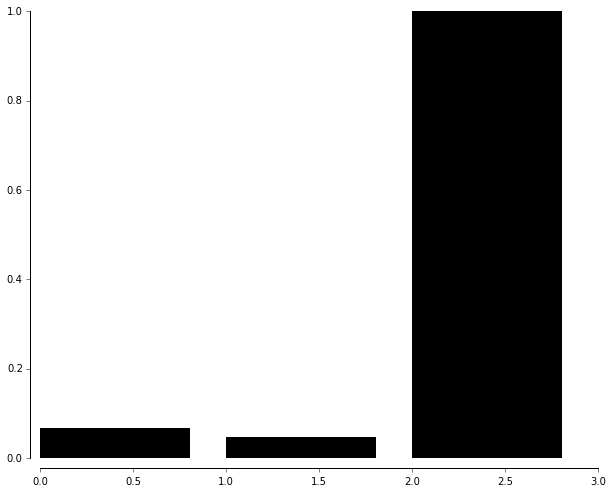

In [415]:
# interpolate to get experiment and ideal on same page
min_f       = np.max([np.min(freq_ideal), np.min(freq_expt_both), np.min(freq_expt_a), np.min(freq_expt_h)])
max_f       = np.min([np.max(freq_ideal), np.max(freq_expt_both), np.max(freq_expt_a), np.max(freq_expt_h)])
valid_freqs = np.linspace(min_f, max_f, 10)

h_filt = interp1d(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h))
a_filt = interp1d(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a))
b_filt = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both))
t_filt = interp1d(freq_ideal, filt_ideal/np.nanmax(filt_ideal))

test_freqs = np.linspace(min_f, 0.12, 100)

h_errors = np.mean((h_filt(test_freqs) - t_filt(test_freqs))**2)
a_errors = np.mean((a_filt(test_freqs) - t_filt(test_freqs))**2)
b_errors = np.mean((b_filt(test_freqs) - t_filt(test_freqs))**2)
errors = [b_errors/h_errors, b_errors/a_errors, b_errors/b_errors]
#yerrs  = [sem(((b_filt(test_freqs) - t_filt(test_freqs))**2)/(x(test_freqs) - t_filt(test_freqs))**2) for x in [h_filt, a_filt, b_filt]]
bar(arange(3), errors, color='k') #, yerr=yerrs, ecolor='k', error_kw={'capthick':10, 'linewidth':10, 'capsize':10})

tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(gca(), ['left', 'bottom'])

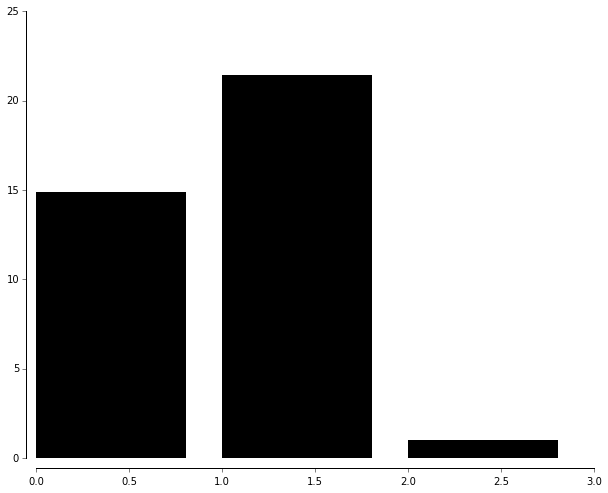

In [425]:
# interpolate to get experiment and ideal on same page
min_f       = np.max([np.min(freq_ideal), np.min(freq_expt_both), np.min(freq_expt_a), np.min(freq_expt_h)])
max_f       = np.min([np.max(freq_ideal), np.max(freq_expt_both), np.max(freq_expt_a), np.max(freq_expt_h)])
valid_freqs = np.linspace(min_f, max_f, 10)

h_filt = interp1d(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h))
a_filt = interp1d(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a))
b_filt = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both))
t_filt = interp1d(freq_ideal, filt_ideal/np.nanmax(filt_ideal))

test_freqs = np.linspace(min_f, 0.12, 100)

h_errors = np.mean((h_filt(test_freqs) - t_filt(test_freqs))**2)
a_errors = np.mean((a_filt(test_freqs) - t_filt(test_freqs))**2)
b_errors = np.mean((b_filt(test_freqs) - t_filt(test_freqs))**2)
errors = [h_errors/b_errors, a_errors/b_errors, b_errors/b_errors]
#yerrs  = [sem(((x(test_freqs) - t_filt(test_freqs))**2)/(b_filt(test_freqs) - t_filt(test_freqs))**2) for x in [h_filt, a_filt, b_filt]]
bar(arange(3), errors, color='k')#, yerr=yerrs, ecolor='k', error_kw={'capthick':10, 'linewidth':10, 'capsize':10})

tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(gca(), ['left', 'bottom'])
#ylim([0, 24])

# Added statistics flag to get all rf_ffts

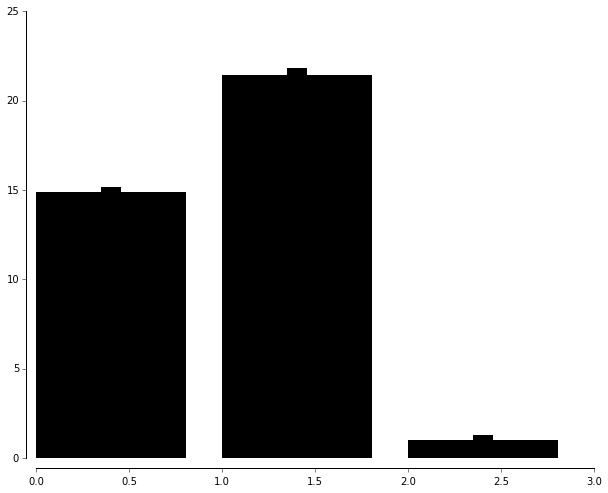

In [450]:
# interpolate to get experiment and ideal on same page
min_f       = np.max([np.min(freq_ideal), np.min(freq_expt_both), np.min(freq_expt_a), np.min(freq_expt_h)])
max_f       = np.min([np.max(freq_ideal), np.max(freq_expt_both), np.max(freq_expt_a), np.max(freq_expt_h)])
valid_freqs = np.linspace(min_f, max_f, 10)

h_filt = interp1d(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h))
a_filt = interp1d(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a))
b_filt = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both))
t_filt = interp1d(freq_ideal, filt_ideal/np.nanmax(filt_ideal))

test_freqs = np.linspace(min_f, 0.12, 100)

h_errors = np.mean((h_filt(test_freqs) - t_filt(test_freqs))**2)
a_errors = np.mean((a_filt(test_freqs) - t_filt(test_freqs))**2)
b_errors = np.mean((b_filt(test_freqs) - t_filt(test_freqs))**2)
errors = [h_errors/b_errors, a_errors/b_errors, b_errors/b_errors]

h_yerr = []
a_yerr = []
b_yerr = []

for h_fft in h_ffts:
    for a_fft in a_ffts:
        for b_fft in both_ffts:
            h_filt = interp1d(h_freqs, h_fft/np.nanmax(h_fft))
            a_filt = interp1d(a_freqs, a_fft/np.nanmax(a_fft))
            b_filt = interp1d(both_freqs, b_fft/np.nanmax(b_fft))
            
            h_errors = np.mean((h_filt(test_freqs) - t_filt(test_freqs))**2)
            a_errors = np.mean((a_filt(test_freqs) - t_filt(test_freqs))**2)
            b_errors = np.mean((b_filt(test_freqs) - t_filt(test_freqs))**2)
            
            h_yerr.append(h_errors/b_errors)
            a_yerr.append(a_errors/b_errors)
            b_yerr.append(b_errors/b_errors)

yerrs  = [sem(h_yerr), sem(a_yerr), sem(b_yerr)]
bar(arange(3), errors, color='k', yerr=yerrs, ecolor='k', error_kw={'capthick':10, 'linewidth':10, 'capsize':10})

tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(gca(), ['left', 'bottom'])
#ylim([0, 24])

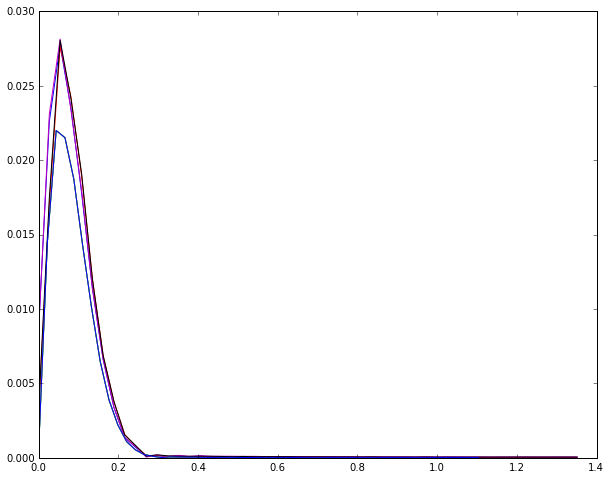

In [448]:
for b in both_ffts:
    plot(both_freqs, b)
    plot(freq_expt_both, filt_expt_both)

In [454]:
input_noise  = 0.2
output_noise = 0.42
np.mean(originalSpectra**2 / ((input_noise * originalSpectra)**2 + output_noise**2))

0.032663710622717397

# Compute information for all three cases of H, A, and H+A

In [209]:
def Gaussian_info_from_freq_spectrum(signal_freq, signal_amp, filt_freq, filt_amp, input_noise, output_noise, 
                                     cutoff=0.3, npoints=100, plot_flag=False):
    # first normalize
    signal_amp = signal_amp / np.nanmax(signal_amp)
    filt_amp   = filt_amp / np.nanmax(filt_amp)
    
    signal_amp_interp = interp1d(signal_freq, signal_amp, kind='slinear')
    filt_amp_interp   = interp1d(filt_freq, filt_amp, kind='slinear')
    
    common_freqs = np.linspace(np.max([np.min(signal_freq), np.min(filt_freq)]), cutoff, npoints)
    signal_amp   = signal_amp_interp(common_freqs)
    filt_amp     = filt_amp_interp(common_freqs)
    
    if plot_flag:
        plot(common_freqs, signal_amp, 'b', linewidth=5)
        plot(common_freqs, ((input_noise**2 * filt_amp) + output_noise**2), 'c', linewidth=5)
    
    SNR = np.mean(signal_amp)**2 / np.mean(((input_noise * filt_amp) + output_noise))**2

    return 0.5 * np.log2(1 + SNR)
    

The relative error from this choice of Lagrangian multiplier is 1.17939531706e-07.


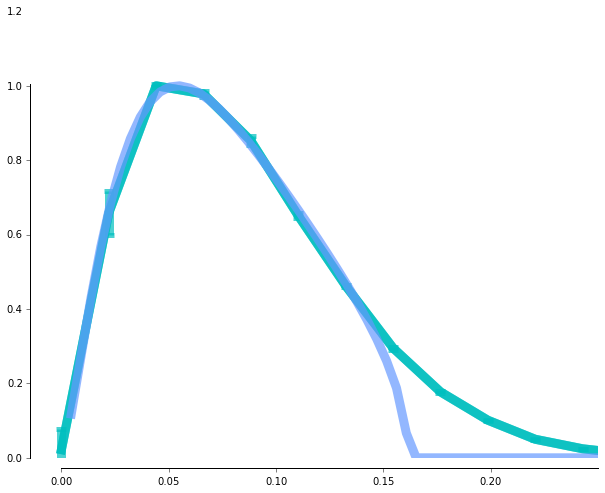

In [210]:
freq_ideal, filt_ideal, freq_expt_both, filt_expt_both, both_freqs, both_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=7.7844, surround_weighting=.5085,
                                                                     horz_weighting=.223, ama_weighting=1.165,
                                                                     center_width=1.86945,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate',
                                                                                       statistics=True)

0.22049827504233652

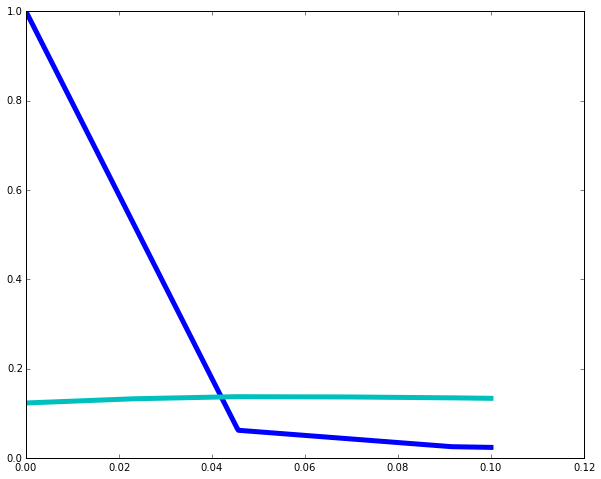

In [211]:
Gaussian_info_from_freq_spectrum(originalFreqs, originalSpectra, freq_expt_both, filt_expt_both, 
                                 0.12, 0.35, cutoff=0.1, plot_flag=True, npoints=500)

0.17128120688784876

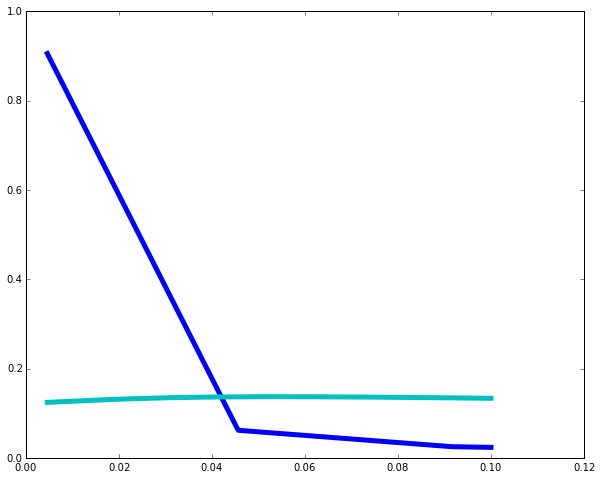

In [212]:
Gaussian_info_from_freq_spectrum(originalFreqs, originalSpectra, freq_ideal, filt_ideal, 
                                 0.12, 0.35, cutoff=0.1, plot_flag=True, npoints=500)

0.17128120688784876

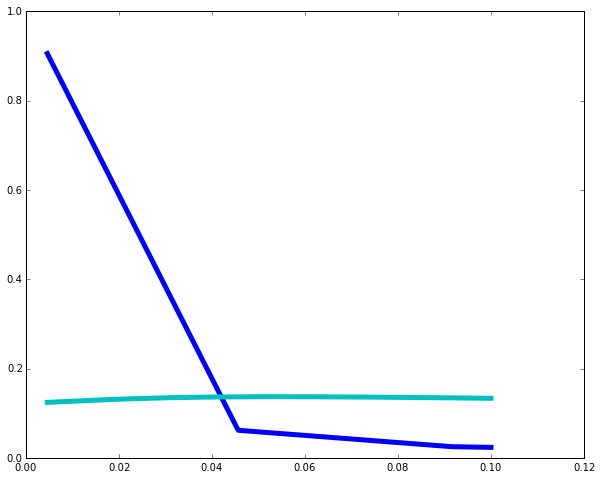

In [213]:
Gaussian_info_from_freq_spectrum(originalFreqs, originalSpectra, freq_ideal, filt_ideal, 
                                 0.12, 0.35, cutoff=0.1, plot_flag=True, npoints=500)

0.22331169603005743

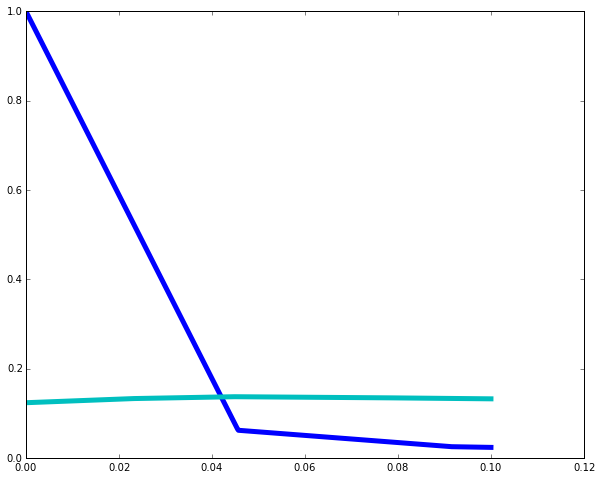

In [214]:
Gaussian_info_from_freq_spectrum(originalFreqs, originalSpectra, freq_expt_h, filt_expt_h, 
                                 0.12, 0.35, cutoff=0.1, plot_flag=True, npoints=500)

0.22150415958477707

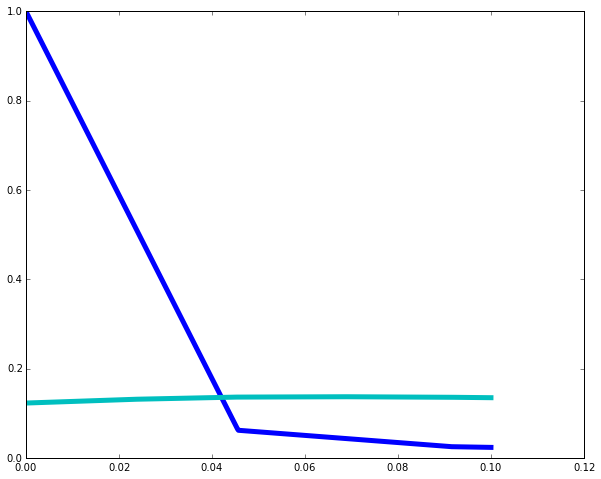

In [215]:
Gaussian_info_from_freq_spectrum(originalFreqs, originalSpectra, freq_expt_a, filt_expt_a, 
                                 0.12, 0.35, cutoff=0.1, plot_flag=True, npoints=500)

# Generate cartoon FFT of center-surround for Figure 2T

(-0.2, 0.5)

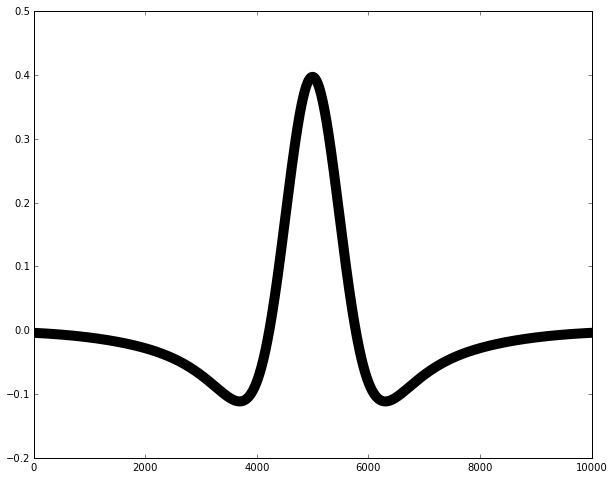

In [374]:
center_surround = gaussian(x=linspace(-5,5,10000),
                           sigma=0.5) - 1*gaussian(x=linspace(-5,5,10000),
                                                   sigma=1) - 2*gaussian(x=linspace(-5,5,10000), sigma=2)
center_surround -= np.mean(center_surround)
plot(center_surround, color='k', linewidth=10)
ylim([-.2, 0.5])

(-0.2, 0.5)

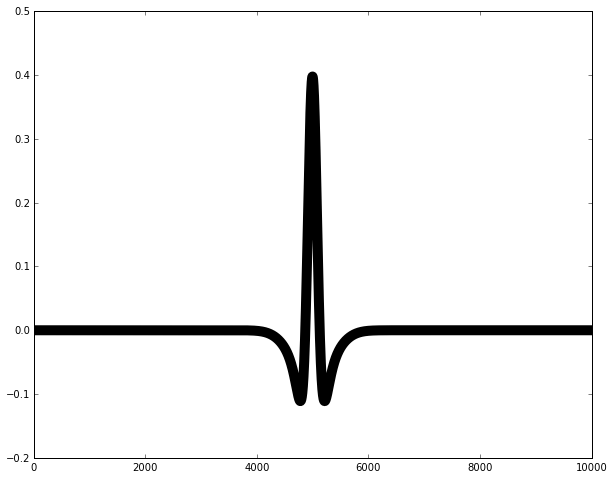

In [382]:
center_surround = gaussian(x=linspace(-30,30,10000),
                           sigma=0.5) - 1*gaussian(x=linspace(-30,30,10000),
                                                   sigma=1) - 2*gaussian(x=linspace(-30,30,10000), sigma=2)
center_surround -= np.mean(center_surround)
plot(center_surround, color='k', linewidth=10)
ylim([-.2, 0.5])

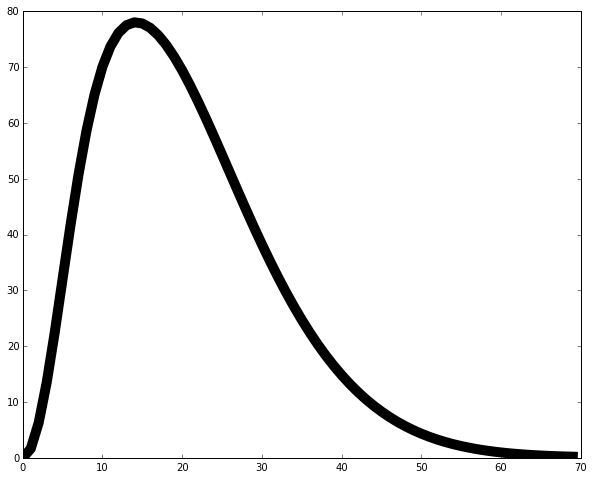

In [384]:
plot(abs(fft(center_surround)[:70]), color='k', linewidth=10)